In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
from scipy.optimize import curve_fit
from IPython.display import display
from statistics import mean

from matplotlib.pyplot import figure

In [2]:
anions = ["BF4", "Cl", "PF6", "PFSI", "TFO", "AlCl4", "TFSI", "Br"]
#anions = ["AlCl4", "BF4", "Cl", "Br"]

In [33]:
def diffusion_fit(t, D, tau, alpha, gamma):
    return D*np.power((np.power(t/tau, -(1-alpha)*gamma)+1), 1/gamma)

# Anion Analysis

## Diffusivity

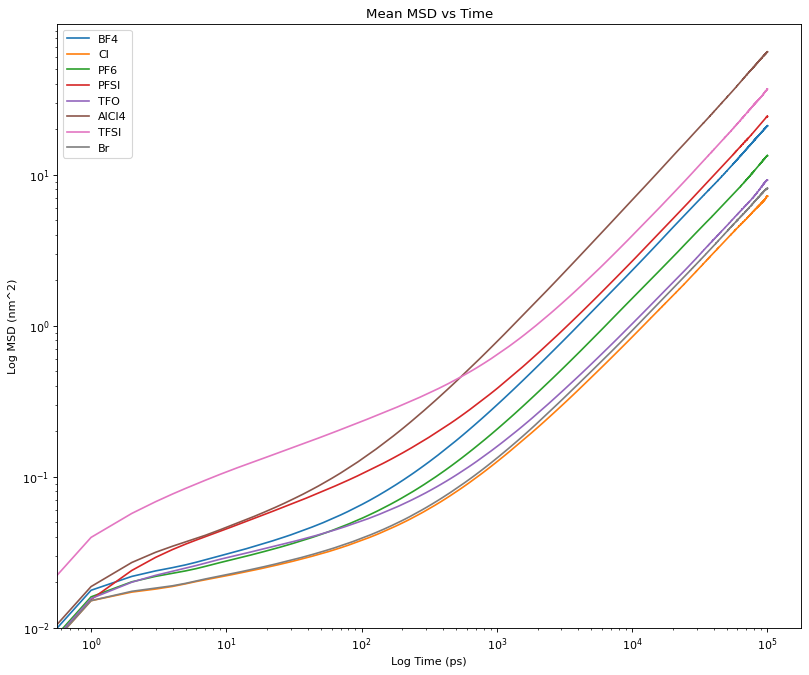

In [3]:
os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
anion_dict = {}
df_dict = {}
slopes_dict = {}
diffs_dict = {}
beta_dict = {}

figure(figsize=(12, 10), dpi=80)

for i in anions:
    os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
    os.chdir(str(i))
    # Formats file name to include current anion
    f_name = "msd_{}_1.xvg"
    
    # Creates and adds DataFrame of each anion's sample 1 MSD to dictionary of MSDs
    anion_dict["data_{}".format(i)] = pd.DataFrame(np.loadtxt(f_name.format(i)), columns = ["Time", "MSD1"])
    # Adds MSD of samples 2-5 for each anion to the same dataframe
    for j in range(2, 6):
        file = "msd_{}_{}.xvg".format(i, j)
        m_dat = np.loadtxt(file.format(j))
        col_name = "MSD{}"
        anion_dict["data_{}".format(i)][col_name.format(j)] = m_dat[:, 1].tolist()
    
    # Averages all sample MSDs for each anion to create Mean MSD
    anion_dict["data_{}".format(i)]["Mean_MSD"] = anion_dict["data_{}".format(i)].iloc[:, 1:5].mean(axis = 1)
    #print("MSD vs Time for " + i)
    #display(anion_dict["data_{}".format(i)].head())
    
    # Log-Log Plot of Time vs Mean MSD for each anion
    plt.plot("Time", "Mean_MSD", data = anion_dict["data_{}".format(i)], label = i)
    plt.xlabel("Log Time (ps)")
    plt.ylabel("Log MSD (nm^2)")
    plt.title("Mean MSD vs Time")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    
    # Takes data from 20000 ns to 80000 ns (Diffusive Region)
    df_dict["df_{}".format(i)] = anion_dict["data_{}".format(i)][anion_dict["data_{}".format(i)]["Time"].between(20000, 80000)]
    
    # Gets times and Mean MSDs for each anion within diffusive region
    time = df_dict["df_{}".format(i)]["Time"]
    msd = df_dict["df_{}".format(i)]["Mean_MSD"]
    
    # Computes slope of line of best fit from times and Mean MSDs
    slopes_dict[i] = np.polyfit(time.values, msd.values, 1)[0]
    diffs_dict[i] = slopes_dict[i] / 6
    
    # Get Beta Value as Slope of Log-Log Plot of MSD vs Time over Diffusive Region
    log_time = np.log(df_dict["df_{}".format(i)]["Time"])
    log_msd = np.log(df_dict["df_{}".format(i)]["Mean_MSD"])
    
    beta_dict[i] = np.polyfit(log_time.values, log_msd.values, 1)[0]

In [4]:
def calc_diff(time, msd):
    slope = np.polyfit(time, msd, 1)[0]
    diff = slope / 6.0
    log_time = np.log1p(time)
    log_msd = np.log1p(msd)
    
    #beta = np.polyfit(log_time.values, log_msd.values, 1)[0]
    diff *= 0.01 #Converts to cm^2/s
    return diff

In [5]:
msd_bf4, msd_cl, msd_pf6, msd_pfsi, msd_tfo, msd_al4, msd_tfsi, msd_br = anion_dict.values()
msd_br

,Time,MSD1,MSD2,MSD3,MSD4,MSD5,Mean_MSD
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.015159,0.015024,0.015092,0.015076,0.014817,0.015088
2,2.0,0.017540,0.017239,0.017467,0.017341,0.016976,0.017397
3,3.0,0.018447,0.018023,0.018404,0.018248,0.017818,0.018281
4,4.0,0.019138,0.018591,0.019113,0.018878,0.018445,0.018930
...,...,...,...,...,...,...,...
99996,99996.0,8.574250,6.654110,9.008070,8.116090,6.278750,8.088130
99997,99997.0,8.563060,6.624940,9.081510,8.080730,6.277210,8.087560
99998,99998.0,8.606010,6.640380,9.064450,8.106990,6.277430,8.104457
99999,99999.0,8.529410,6.685140,9.006200,8.108720,6.288080,8.082368


In [6]:
run_time = msd_bf4["Time"]

In [7]:
diff_anion = pd.DataFrame(columns = ["Anion", "Mean Diffusivity", "Std. Dev Diffusivity"])
diff_anion["Anion"] = anions
diff_anion

,Anion,Mean Diffusivity,Std. Dev Diffusivity
0,BF4,NaN,NaN
1,Cl,NaN,NaN
2,PF6,NaN,NaN
3,PFSI,NaN,NaN
4,TFO,NaN,NaN
5,AlCl4,NaN,NaN
6,TFSI,NaN,NaN
7,Br,NaN,NaN


In [8]:
msd_list = [msd_bf4, msd_cl, msd_pf6, msd_pfsi, msd_tfo, msd_al4, msd_tfsi, msd_br]
for ind, i in enumerate(msd_list):
    anion_curr = anions[ind]
    i.drop(columns = ["Time", "Mean_MSD"], inplace = True)
    #diff_list = i.apply(lambda x: calc_diff(run_time.values, x.values), axis = 0)
    diff_list = []
    for j in list(i.columns):
        diff_list.append(calc_diff(run_time.values, i[j].values))
    #print(diff_list)
    diff_anion.loc[(diff_anion["Anion"] == anion_curr), "Mean Diffusivity"] = mean(diff_list)
    diff_anion.loc[(diff_anion["Anion"] == anion_curr), "Std. Dev Diffusivity"] = np.std(diff_list)

In [9]:
diff_anion.style.format({
    "Mean Diffusivity":"{:,.6E}".format,
    "Std. Dev Diffusivity":"{:,.6E}".format})

,Anion,Mean Diffusivity,Std. Dev Diffusivity
0,BF4,3.488267E-07,4.309947E-08
1,Cl,1.194257E-07,1.712036E-08
2,PF6,2.227080E-07,4.501755E-08
3,PFSI,3.973581E-07,4.025948E-08
4,TFO,1.645033E-07,3.696477E-08
5,AlCl4,1.098127E-06,7.592233E-08
6,TFSI,6.063797E-07,1.811050E-08
7,Br,1.287339E-07,1.764074E-08


In [10]:
#pd.set_option('display.float_format', '{:.6g}'.format)

# Adds dictionaries of anions, diffusivities, and beta values to new DataFrame
diffs_df = pd.DataFrame(list(diffs_dict.items()), columns = ["Anion", "Diffusivity (nm^2/ps)"])
diffs_df["Beta"] = diffs_df["Anion"].map(beta_dict)
diffs_df["Diffusivity (cm^2/s)"] = diffs_df["Diffusivity (nm^2/ps)"] * 0.01
diffs_df = diffs_df.drop(columns = ["Diffusivity (nm^2/ps)"])
diffs_df["Std. Dev Diffusivity"] = list(diff_anion["Std. Dev Diffusivity"])

# Formats Diffusivities to scientific notation and Betas to Standard
diffs_df.style.format({
    "Diffusivity (cm^2/s)":"{:,.6E}".format,
    "Beta":"{:,.5f}".format,
    "Std. Dev Diffusivity":"{:,.6E}".format})

,Anion,Beta,Diffusivity (cm^2/s),Std. Dev Diffusivity
0,BF4,0.95783,3.430480E-07,4.309947E-08
1,Cl,0.94091,1.171041E-07,1.712036E-08
2,PF6,0.94284,2.130360E-07,4.501755E-08
3,PFSI,0.96278,3.946085E-07,4.025948E-08
4,TFO,0.95353,1.462493E-07,3.696477E-08
5,AlCl4,0.99008,1.081517E-06,7.592233E-08
6,TFSI,0.98404,6.022451E-07,1.811050E-08
7,Br,0.95579,1.341126E-07,1.764074E-08


In [11]:
# Diffusivities from Jordan's Paper at 600 K
j_diffs = {"BF4":2.4266*10**-7, "Cl":1.0233*10**-7, "PFSI":1.3032*10**-7, "TFO":8.7599*10**-8, "AlCl4":2.8347*10**-7, "TFSI":3.0903*10**-7, "Br":1.7478*10**-7}
j_df = pd.DataFrame(list(j_diffs.items()), columns = ["Anion", "Diffusivity from Paper (cm^2/s)"])
j_df

,Anion,Diffusivity from Paper (cm^2/s)
0,BF4,2.426600e-07
1,Cl,1.023300e-07
2,PFSI,1.303200e-07
3,TFO,8.759900e-08
4,AlCl4,2.834700e-07
5,TFSI,3.090300e-07
6,Br,1.747800e-07


In [18]:
list(diff_anion["Mean Diffusivity"])

[3.488266940932928e-07,
 1.1942566334190379e-07,
 2.2270798000093218e-07,
 3.9735809105135504e-07,
 1.6450332660738988e-07,
 1.0981269533862838e-06,
 6.063797051079893e-07,
 1.2873388144091137e-07]

## Partial Conductivity

In [21]:
# Volume Calculation
anions = ["BF4", "Cl", "PF6", "PFSI", "TFO", "AlCl4", "TFSI", "Br"]
msd_list = [msd_bf4, msd_cl, msd_pf6, msd_pfsi, msd_tfo, msd_al4, msd_tfsi, msd_br]
diff_list = list(diffs_df["Diffusivity (cm^2/s)"])

box_x = [4.78088*10**-9, 4.50819*10**-9, 4.93025*10**-9, 5.77273*10**-9, 4.94393*10**-9, 5.24735*10**-9, 5.36238*10**-9, 4.53440*10**-9] # From prod.gro, in m
V_anion = [x**3 for x in box_x]

# Number Density Calculation; From topol.top
N_an = 300 
N_cat = 20

q = 1.602176634*10**-19 # +1 e in Coulombs

k_b = 1.380649*10**-23 # Boltzmann Constant in m^2 kg s^-2 K^-1

T = 600 # From grompp.mdp, in K

number_density = [N_an/V for V in V_anion]

x = N_an/(N_an + N_cat)

s_minus = []
for ind, i in enumerate(anions):
    sigma_minus = (number_density[i[0]]*q**2/(k_b*T))*(N_an*q)**2*diff_list[i]
    s_minus.append()

s_minus


TypeError: list indices must be integers or slices, not str

## NE Conductivity

In [12]:
# Nernst-Einstein Conductivity Calculation
# s_NE = (N_pair/(V*k_b*T))*(q+^2*D)

# Volume Calculation
box_x = [4.78088*10**-9, 4.50819*10**-9, 4.93025*10**-9, 5.77273*10**-9, 4.94393*10**-9, 5.24735*10**-9, 5.36238*10**-9, 4.53440*10**-9] # From prod.gro, in m
V_anion = [x**3 for x in box_x]

# N_pair Calculation; From topol.top
N_an = 300 
N_cat = 20
N_pair = N_an + N_cat

k_b = 1.380649*10**-23 # Boltzmann Constant in m^2 kg s^-2 K^-1

T = 600 # From grompp.mdp, in K
q = 1.602176634*10**-19 # +1 e in Coulombs

m_c = 15
d = [(m_c + N_cat)/V for V in V_anion] # Number Density

NE_list = []
anion_list = list(diffs_df["Anion"])
diff_list = list(diffs_df["Diffusivity (cm^2/s)"])

s_ne = 0.0
diff = 0.0

for i in range(len(anion_list)):
    diff = diff_list[i]/10000 # Diffusivity in m^2/s
    s_ne = ((q**2)/(k_b*T))*d[i]*((N_cat/(N_cat + 1))*diff) # S/m
    s_ne *= 10
    NE_list.append(s_ne)
    
print(NE_list)

[0.3242622174985438, 0.13201723341640453, 0.18361623658965137, 0.2118788995508268, 0.1250091478391445, 0.773175865322734, 0.4034275078504045, 0.14858504054549196]


In [13]:
diffs_df["Nernst-Einstein Conductivity (mS/cm)"] = NE_list

In [14]:
diffs_df

,Anion,Beta,Diffusivity (cm^2/s),Std. Dev Diffusivity,Nernst-Einstein Conductivity (mS/cm)
0,BF4,0.957834,3.430480e-07,4.309947e-08,0.324262
1,Cl,0.940908,1.171041e-07,1.712036e-08,0.132017
2,PF6,0.942844,2.130360e-07,4.501755e-08,0.183616
3,PFSI,0.962775,3.946085e-07,4.025948e-08,0.211879
4,TFO,0.953531,1.462493e-07,3.696477e-08,0.125009
5,AlCl4,0.990084,1.081517e-06,7.592233e-08,0.773176
6,TFSI,0.984043,6.022451e-07,1.811050e-08,0.403428
7,Br,0.955787,1.341126e-07,1.764074e-08,0.148585


<AxesSubplot:title={'center':'Anion Diffusivity for Each Anion'}, xlabel='Anion', ylabel='Diffusivity (cm^2/s)'>

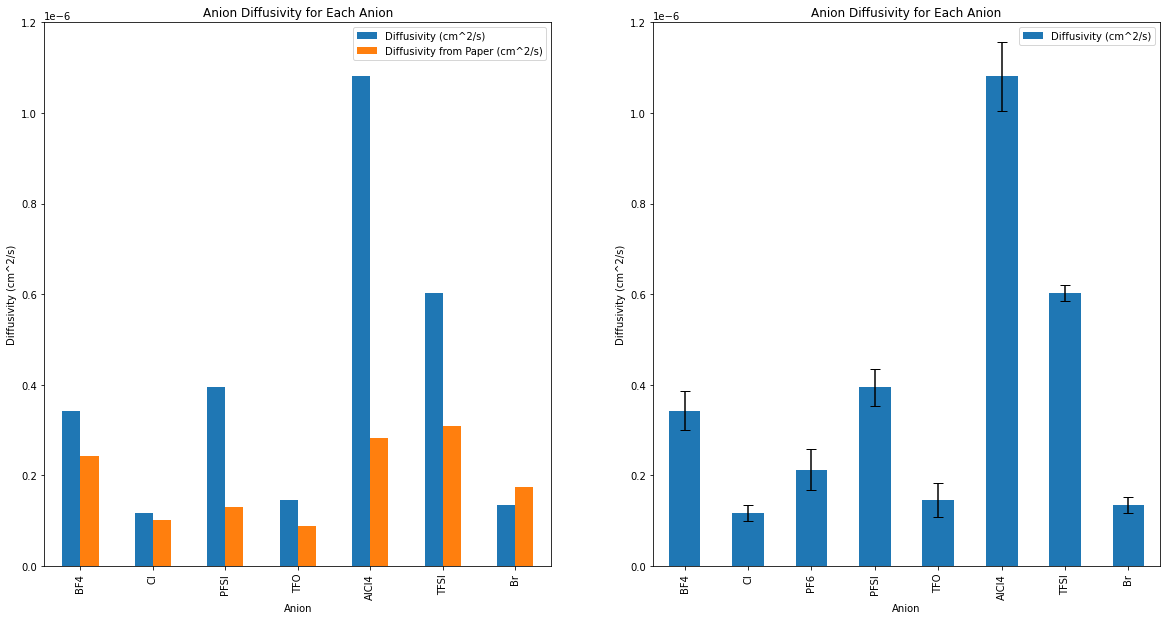

In [15]:
an_bar_df = pd.merge(diffs_df, j_df, on = "Anion")
an_bar_df = an_bar_df[["Anion", "Diffusivity (cm^2/s)", "Diffusivity from Paper (cm^2/s)"]]

# Bar Graph of Anion Diffusivities Compared to Paper
fig, axes = plt.subplots(nrows = 1, ncols = 2)
an_bar_df.plot(x = "Anion", kind = "bar", ylim = (0, 1.2*10**-6),
              title = "Anion Diffusivity for Each Anion", xlabel = "Anion", 
               ylabel = "Diffusivity (cm^2/s)", ax = axes[0], figsize = (20, 10))

# Bar Graph of Anion Diffusivities with Error Bars
diffs_df.plot(x = "Anion", y = "Diffusivity (cm^2/s)", kind = "bar", ylim = (0, 1.2*10**-6), 
              yerr = list(diff_anion["Std. Dev Diffusivity"]), capsize = 5,
              title = "Anion Diffusivity for Each Anion", ax = axes[1], 
              xlabel = "Anion", ylabel = "Diffusivity (cm^2/s)", figsize = (20, 10))

[Text(0, 0, '0.246174'),
 Text(0, 0, '0.0840348'),
 Text(0, 0, '0.152876'),
 Text(0, 0, '0.283174'),
 Text(0, 0, '0.10495'),
 Text(0, 0, '0.776105'),
 Text(0, 0, '0.432176'),
 Text(0, 0, '0.0962402')]

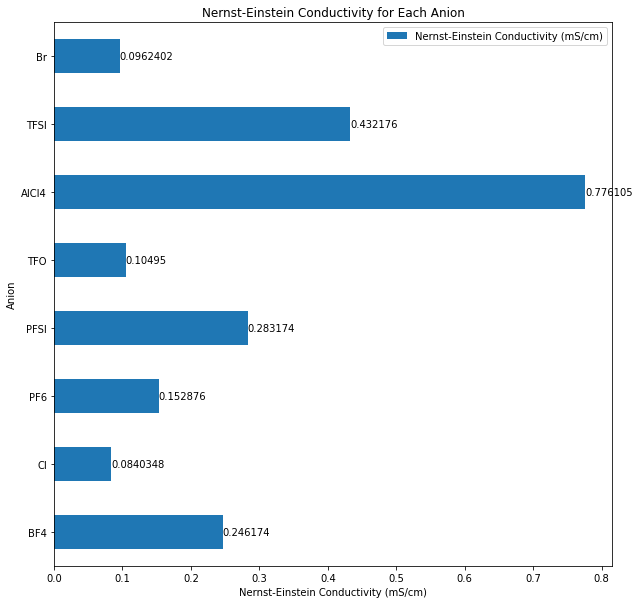

In [16]:
# Bar Graph of NE Conductivity for Each Anion
ax = diffs_df.plot(x = "Anion", y = "Nernst-Einstein Conductivity (mS/cm)", kind = "barh", 
              title = "Nernst-Einstein Conductivity for Each Anion", figsize = (10, 10))
ax.set_ylabel("Anion")
ax.set_xlabel("Nernst-Einstein Conductivity (mS/cm)")
ax.bar_label(ax.containers[0])

# Cation Analysis (DO NOT USE)

## Linear Fit

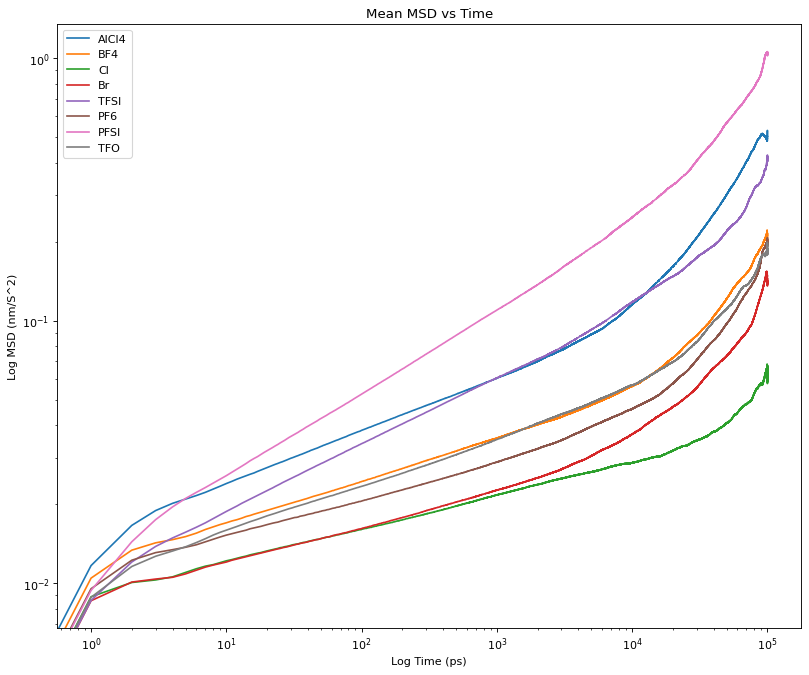

In [11]:
cation_dict = {}
lin_cat_diff_dict = {}
cat_diff_dict = {}
cation_diffusivities_dict = {}

anions = ["AlCl4", "BF4", "Cl", "Br", "TFSI", "PF6", "PFSI", "TFO"] #Comment this once all cation msds are obtained

os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")

figure(figsize=(12, 10), dpi=80)

for i in anions:
    os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
    os.chdir(str(i))
    f_name = "msd_cat_{}_1.xvg"
    cation_dict["data_{}".format(i)] = pd.DataFrame(np.loadtxt(f_name.format(i)), columns = ["Time", "MSD1"])
    # Adds MSD of samples 2-5 for each anion to the same dataframe
    for j in range(2, 6):
        file = "msd_cat_{}_{}.xvg".format(i, j)
        m_dat = np.loadtxt(file.format(j))
        col_name = "MSD{}"
        cation_dict["data_{}".format(i)][col_name.format(j)] = m_dat[:, 1].tolist()
    
    # Averages all sample MSDs for each anion to create Mean MSD
    cation_dict["data_{}".format(i)]["Mean_MSD"] = cation_dict["data_{}".format(i)].iloc[:, 1:5].mean(axis = 1)
    #print("MSD vs Time for Cation in " + i)
    #display(cation_dict["data_{}".format(i)].head())
    
    # Log-Log Plot of Time vs Mean MSD for each anion
    plt.plot("Time", "Mean_MSD", data = cation_dict["data_{}".format(i)], label = i)
    plt.xlabel("Log Time (ps)")
    plt.ylabel("Log MSD (nm/S^2)")
    plt.title("Mean MSD vs Time")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
 
    # Takes data from 20000 ns to 80000 ns (Diffusive Region)
    df_dict["df_{}".format(i)] = cation_dict["data_{}".format(i)][cation_dict["data_{}".format(i)]["Time"].between(20000, 80000)]
    
    # Gets times and Mean MSDs for each anion within diffusive region
    time = df_dict["df_{}".format(i)]["Time"]
    msd = df_dict["df_{}".format(i)]["Mean_MSD"]
    
    # Computes slope of line of best fit from times and Mean MSDs
    slopes_dict[i] = np.polyfit(time.values, msd.values, 1)[0]
    lin_cat_diff_dict[i] = slopes_dict[i] / 6
    
    # Get Beta Value as Slope of Log-Log Plot of MSD vs Time over Diffusive Region
    log_time = np.log(df_dict["df_{}".format(i)]["Time"])
    log_msd = np.log(df_dict["df_{}".format(i)]["Mean_MSD"])
    
    beta_dict[i] = np.polyfit(log_time.values, log_msd.values, 1)[0]

## Non-Linear Fit with scipy.curve_fit

Non-Linear Fit Parameters for BF4
Diffusivity for time 20000 to 21000 ps 2.0314394530253596e-05
Diffusivity for time 20000 to 40000 ps 3.384371755264536e-06
Diffusivity for time 20000 to 120000 ps 1.0000001895526769e-08


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


Non-Linear Fit Parameters for Cl
Diffusivity for time 20000 to 21000 ps 1.3338575961025797e-05
Diffusivity for time 20000 to 40000 ps 1.6456497668276093e-06
Diffusivity for time 20000 to 120000 ps 5.991507921671928e-07


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


Non-Linear Fit Parameters for PF6
Diffusivity for time 20000 to 21000 ps 1.9908635688079856e-05
Diffusivity for time 20000 to 40000 ps 2.309438849607252e-06
Diffusivity for time 20000 to 120000 ps 1.000073526508169e-08


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


Non-Linear Fit Parameters for PFSI
Diffusivity for time 20000 to 21000 ps 1e-08
Diffusivity for time 20000 to 40000 ps 1e-08
Diffusivity for time 20000 to 120000 ps 1.0000011252767653e-08


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


Non-Linear Fit Parameters for TFO
Diffusivity for time 20000 to 21000 ps 2.179779286985988e-05
Diffusivity for time 20000 to 40000 ps 2.8239791779031537e-06
Diffusivity for time 20000 to 120000 ps 1.0014544077396399e-08


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


Non-Linear Fit Parameters for TFSI
Diffusivity for time 20000 to 21000 ps 1e-08
Diffusivity for time 20000 to 40000 ps 1e-08
Diffusivity for time 20000 to 120000 ps 1.0000044839646363e-08


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


Non-Linear Fit Parameters for Br
Diffusivity for time 20000 to 21000 ps 1e-08
Diffusivity for time 20000 to 40000 ps 1e-08
Diffusivity for time 20000 to 120000 ps 1.0000059251371229e-08


C:\Users\User\AppData\Local\Temp/ipykernel_7420/3605189408.py:83: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.xscale("Log")


<Figure size 960x800 with 0 Axes>

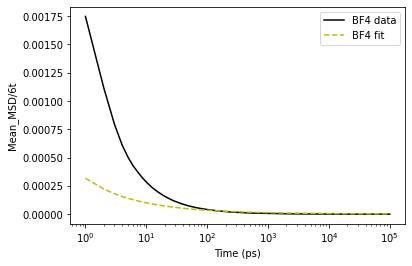

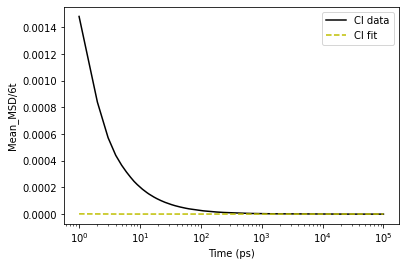

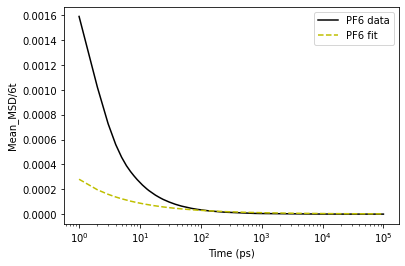

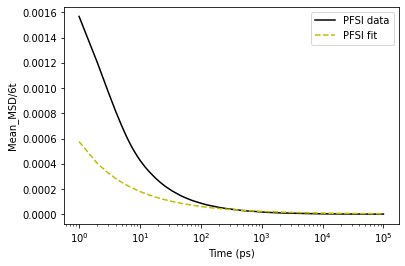

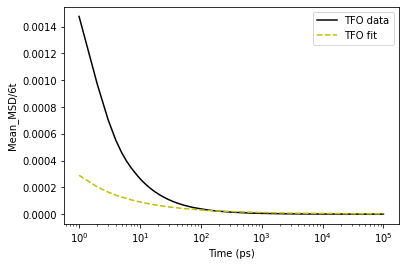

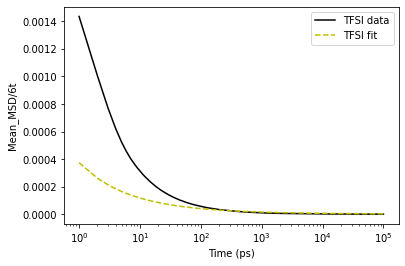

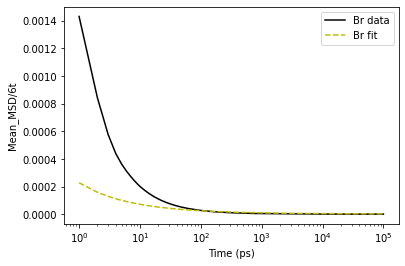

In [110]:


cation_dict = {}
cat_diff_dict = {}
cation_diffusivities_dict = {}

#anions = ["BF4", "Br"] #Comment this once all cation msds are obtained

os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")

figure(figsize=(12, 10), dpi=80)

for i in anions:
    popt_fit = []
    pcov_fit = []
    popt_temp = 0
    pcov_temp = 0
    popt = 0
    pcov = 0
    if i == "BF4":
        os.chdir(""+str(i))
    else:
        os.chdir("../"+str(i))
    f_name = "msd_cat_{}_1.xvg"
    cation_dict["data_{}".format(i)] = pd.DataFrame(np.loadtxt(f_name.format(i)), columns = ["Time", "MSD1"])
    # Adds MSD of samples 2-5 for each anion to the same dataframe
    for j in range(2, 6):
        file = "msd_cat_{}_{}.xvg".format(i, j)
        m_dat = np.loadtxt(file.format(j))
        col_name = "MSD{}"
        cation_dict["data_{}".format(i)][col_name.format(j)] = m_dat[:, 1].tolist()
    
    # Averages all sample MSDs for each anion to create Mean MSD
    cation_dict["data_{}".format(i)]["Mean_MSD"] = cation_dict["data_{}".format(i)].iloc[:, 1:5].mean(axis = 1)
    #print("MSD vs Time for Cation in " + i)
    #display(cation_dict["data_{}".format(i)].head())
    
    # Log-Log Plot of Time vs Mean MSD for each anion
    #plt.plot("Time", "Mean_MSD", data = cation_dict["data_{}".format(i)], label = i)
    #plt.xlabel("Log Time (ps)")
    #plt.ylabel("Log MSD (nm/S^2)")
    #plt.title("Mean MSD vs Time")
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.legend()
 
    # Linear Fit gave low beta values (<0.7 in all cases), so non-linear fit with scipy.optimize.curve_fit is used
    # Non-linear fit to get D
    # Get first fit from point 1 to 1000 ps, then use those as initial values for fit to point 1 to 20000 ps.
    # Use those as initial values for entire data set
    splits = [1000, 20000]
    call_max = 1000000
    method = "dogbox"
    # Get time and msd, drop (0,0) since curve fit fails
    time = cation_dict["data_{}".format(i)]["Time"].drop([0])
    msd = cation_dict["data_{}".format(i)]["Mean_MSD"].drop([0])
    ydat = msd.values / (6*time.values)
    xdat = time.values
    print("Non-Linear Fit Parameters for " + str(i))
    for k in splits:
        df_fit = cation_dict["data_{}".format(i)].iloc[1:k, :]
        time_fit = df_fit["Time"]
        msd_fit = df_fit["Mean_MSD"]
        ydat_fit = msd_fit.values / (6*time_fit.values)
        xdat_fit = time_fit.values
        if k == splits[0]:
            popt_temp, pcov_temp = curve_fit(diffusion_fit, xdat_fit, ydat_fit, p0 = [3e-5, 0.5, 0.5, 0.5],
                                             bounds = ((1e-8, 1e-2, 1e-2, 1e-2), (1e-4, 5, 5, 5)), method = method, maxfev = call_max)
        else:
            popt_temp, pcov_temp = curve_fit(diffusion_fit, xdat_fit, ydat_fit, p0 = popt_fit[-1], 
                                             bounds = ((1e-8, 1e-2, 1e-2, 1e-2), (1e-4, 5, 5, 5)), method = method, maxfev = call_max)
        print("Diffusivity for time 20000 to " + str(k + 20000) + " ps " + str(popt_temp[0]))
        popt_fit.append(popt_temp)
        pcov_fit.append(pcov_temp)
    
    popt, pcov = curve_fit(diffusion_fit, xdat, ydat, p0 = popt_fit[-1], 
                           bounds = ((1e-8, 1e-2, 1e-2, 1e-2), (1e-4, 5, 5, 5)), maxfev = call_max)
    print("Diffusivity for time 20000 to 120000 ps " + str(popt[0]))
    cation_diffusivities_dict[i] = popt[0] 
    plt.figure()
    plt.plot(xdat, ydat, "k-", label = str(i) + " data")
    plt.plot(xdat, diffusion_fit(xdat, *popt), "y--", label = str(i) + " fit")
    plt.xlabel("Time (ps)")
    plt.ylabel("Mean_MSD/6t")
    plt.xscale("Log")
    plt.legend()
    plt.legend()
    


## Non-linear Fit with lmfit

In [20]:
from lmfit import Parameters, minimize, fit_report

In [67]:
def diff_fit(params, t, y):
    D = params["D"]
    alpha = params["alpha"]
    gamma = params["gamma"]
    tau = params["tau"]
    y_fit = D*np.power((np.power(t/tau, -(1-alpha)*gamma)+1), 1/gamma)
    return y_fit - y

In [ ]:
fitted_params = minimize(diff_fit, params, args = (x, y), maxfev = 100000)

Non-Linear Fit Parameters for BF4
Diffusivity for time 20000 to 20010 ps 9.909076947568517e-05
[9.909076947568517e-05, 0.01000104200757664, 4.999999999092175, 0.3801780526923476]
Diffusivity for time 20000 to 20050 ps 2.113463285045471e-06
[2.113463285045471e-06, 0.010000000125474645, 4.999999999999992, 0.1265359316099789]
Diffusivity for time 20000 to 20075 ps 2.113463285045471e-06
[2.113463285045471e-06, 0.010000000125474645, 4.999999999999992, 0.1265359316099789]
Diffusivity for time 20000 to 20100 ps 2.113463285045471e-06
[2.113463285045471e-06, 0.010000000125474645, 4.999999999999992, 0.1265359316099789]
Diffusivity for time 20000 to 20500 ps 2.028230527484453e-06
[2.028230527484453e-06, 0.010011727651830374, 4.139144178689619, 0.1273676289796404]
Diffusivity for time 20000 to 21000 ps 1.5575034909760882e-06
[1.5575034909760882e-06, 0.010000173360860098, 4.875880135428803, 0.131401429689789]
Diffusivity for time 20000 to 30000 ps 1.5575034909760882e-06
[1.5575034909760882e-06, 0.0

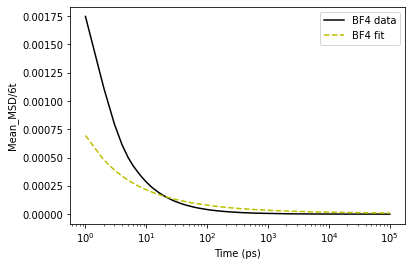

In [108]:
params = Parameters()
params.add("D", value = 3e-7, min = 1e-9, max = 1e-4)
params.add("alpha", value = 0.5, min = 1e-2, max = 5)
params.add("gamma", value = 0.5, min = 1e-2, max= 5)
params.add("tau", value = 0.5, min = 1e-2, max = 5)

splits = [10, 100, 500, 1000, 5000, 10000]
call_max = 1000000
method = "leastsq"
# Get time and msd, drop (0,0) since curve fit fails
time = cation_dict["data_BF4"]["Time"].drop([0])
msd = cation_dict["data_BF4"]["Mean_MSD"].drop([0])
ydat = msd.values / (6*time.values)
xdat = time.values
print("Non-Linear Fit Parameters for " + "BF4")
for k in splits:
    par = []
    df_fit = cation_dict["data_BF4"].iloc[1:k, :]
    time_fit = df_fit["Time"]
    msd_fit = df_fit["Mean_MSD"]
    ydat_fit = msd_fit.values / (6*time_fit.values)
    xdat_fit = time_fit.values
    #print("Parameters: " + str(params))
    fitted_params = minimize(diff_fit, params, args = (xdat_fit, ydat_fit), max_nfev = call_max, method = method)
    print("Diffusivity for time 20000 to " + str(k+20000) + " ps " + str(fitted_params.params["D"].value))
        #cation_diffusivities_dict[i] = fitted_params.params["D"].value
    par.append(fitted_params.params["D"].value)
    par.append(fitted_params.params["alpha"].value)
    par.append(fitted_params.params["tau"].value)
    par.append(fitted_params.params["gamma"].value)  
    params = Parameters()
    params.add("D", value = par[0], min = 1e-9, max = 1e-4)
    params.add("alpha", value = par[1], min = 1e-2, max = 5)
    params.add("gamma", value = par[3], min = 1e-2, max= 5)
    params.add("tau", value = par[2], min = 1e-2, max = 5)
    print(par)
 
fitted_params = minimize(diff_fit, params, args = (xdat, ydat), max_nfev = call_max, method = method)
print("Diffusivity for time 20000 to 120000 ps " + str(fitted_params.params["D"].value))
par.append(fitted_params.params["D"].value)
par.append(fitted_params.params["alpha"].value)
par.append(fitted_params.params["tau"].value)
par.append(fitted_params.params["gamma"].value)
print(fit_report(fitted_params))
plt.figure()
plt.plot(xdat, ydat, "k-", label = "BF4" + " data")
plt.plot(xdat, diffusion_fit(xdat, par[0], par[2], par[1], par[3]), "y--", label = str("BF4") + " fit")
plt.xlabel("Time (ps)")
plt.ylabel("Mean_MSD/6t")
plt.xscale("log")
plt.legend()
plt.legend()

## Short-Time MSDs

AlCl4
Average Diffusivity for 120000-160000 ps: 8.421274854138708e-07
Average Diffusivity for 140000-180000 ps: 7.005663791535722e-07
Average Diffusivity for 160000-200000 ps: 9.445709664681679e-07
Average Diffusivity for 180000-220000 ps: 5.916643591607359e-07
BF4
Average Diffusivity for 120000-160000 ps: 4.059313416045453e-07
Average Diffusivity for 140000-180000 ps: 4.3964160302494346e-07
Average Diffusivity for 160000-200000 ps: 3.73590235706507e-07
Average Diffusivity for 180000-220000 ps: 2.9025217732471363e-07
Cl
Average Diffusivity for 120000-160000 ps: 1.956978556241064e-07
Average Diffusivity for 140000-180000 ps: 1.7753734976131335e-07
Average Diffusivity for 160000-200000 ps: 2.1053259782470113e-07
Average Diffusivity for 180000-220000 ps: 1.7095027253152063e-07
Br
Average Diffusivity for 120000-160000 ps: 2.0701358238484492e-07
Average Diffusivity for 140000-180000 ps: 1.9993876102331057e-07
Average Diffusivity for 160000-200000 ps: 1.8621839189697774e-07
Average Diffusivi

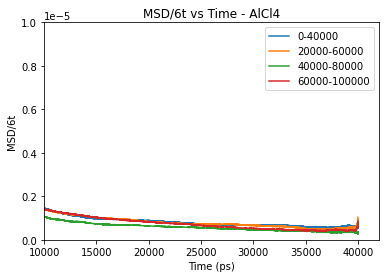

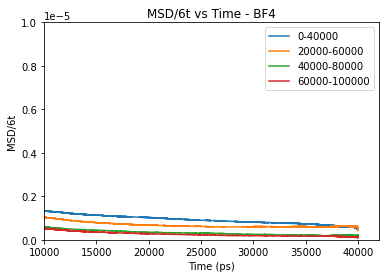

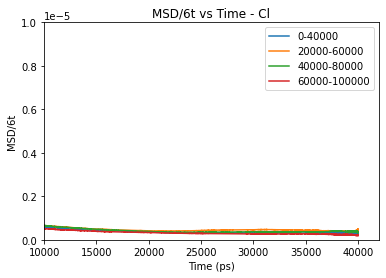

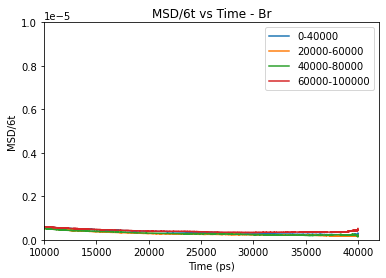

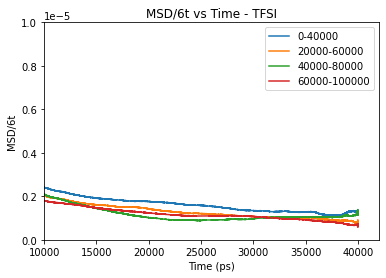

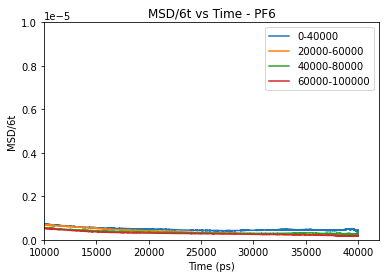

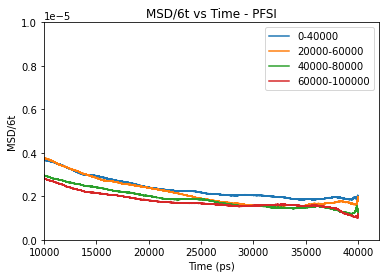

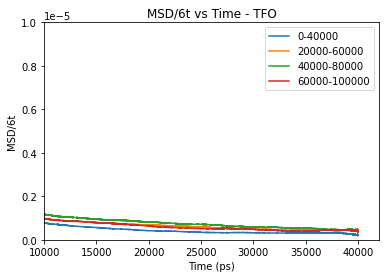

In [16]:
short_dict = {}
short_diff_dict = {}
diff_list = []
short_diffs_dict = {}
splits = [40000, 60000, 80000, 100000]

os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")

anions = ["AlCl4", "BF4", "Cl", "Br", "TFSI", "PF6", "PFSI", "TFO"] #Comment once all msds are obtained

for i in anions:
    if i == "AlCl4":
        os.chdir(""+str(i))
    else:
        os.chdir("../"+str(i))
    plt.figure()
    short_diffs_dict = {}
    print(str(i))
    for j in splits:
        #plt.figure()
        diff_list = []
        low = j - 40000
        file = "msd_cat_{}_1_{}_{}.xvg".format(i, low, j)
        m_dat = np.loadtxt(file)
        ydat = m_dat[1:, 1].tolist()
        xdat = m_dat[1:, 0].tolist()

        yplot = [y / (6*x) for x, y in zip(xdat, ydat)]
        short_dict["data_{}_1_{}_{}".format(i, low, j)] = pd.DataFrame(zip(xdat, yplot), columns = ["Time", "MSD1/6t"])
        bound_low = j - 2000
        avg = short_dict["data_{}_1_{}_{}".format(i, low, j)].iloc[38000:40000, 1].mean()
        short_diff_dict["data_{}_1_{}_{}".format(i, low, j)] = avg
        #print(short_diff_dict)
        diff_list.append(short_diff_dict["data_{}_1_{}_{}".format(i, low, j)])
        plt.plot(xdat, yplot, label = str(low) + "-" + str(j))
        plt.xlabel("Time (ps)")
        plt.ylabel("MSD/6t")
        plt.title("MSD/6t vs Time - " + str(i))
        plt.xlim(10000)
        plt.ylim(0, 1e-5)
        plt.legend()
        for k in range(2, 6):
            #plt.figure()
            #print("Sample " + str(k))
            file = "msd_cat_{}_{}_{}_{}.xvg".format(i, k, low, j)
            m_dat = np.loadtxt(file)
            ydat = m_dat[1:, 1].tolist()
            xdat = m_dat[1:, 0].tolist()
    
            yplot = [y / (6*x) for x, y in zip(xdat, ydat)]
            col_name = "MSD{}/6t"
            short_dict["data_{}_{}_{}_{}".format(i, k, low, j)] = pd.DataFrame(zip(xdat, yplot), columns = ["Time", col_name.format(k)])
            #print(short_dict["data_{}_{}_{}_{}".format(i, k, low, j)][col_name.format(k)].iloc[bound_low:j])
            avg = short_dict["data_{}_{}_{}_{}".format(i, k, low, j)][col_name.format(k)].iloc[38000:40000].mean()
            short_diff_dict["data_{}_{}_{}_{}".format(i, k, low, j)] = avg
            diff_list.append(short_diff_dict["data_{}_{}_{}_{}".format(i, k, low, j)])
            #plt.plot(xdat, yplot, label = str(low) + "-" + str(j))
            #plt.xlim(10000)
            #plt.ylim(0, 1e-5)
            #plt.legend()
            #print(diff_list)
            #short_diffs_dict[i][k] = mean(diff_list)
            #print(short_diffs_dict)
        short_diffs_dict[str(i) + " " + str(low) + "-" + str(j)] = mean(diff_list)
        print("Average Diffusivity for " + str((low+120000)) + "-" + str((j+120000)) + " ps: " + 
              str(short_diffs_dict[str(i) + " " + str(low) + "-" + str(j)]))
    cat_diff_dict[i] = sum(short_diffs_dict.values()) / len(short_diffs_dict)

In [17]:
cat_diff_dict

{'AlCl4': 7.697322975490867e-07,
 'BF4': 3.7735383941517736e-07,
 'Cl': 1.886795189354104e-07,
 'Br': 1.9924867763638195e-07,
 'TFSI': 7.552169322640756e-07,
 'PF6': 3.913461695163365e-07,
 'PFSI': 2.1067196004159597e-06,
 'TFO': 4.47194245683939e-07}

### Energy

In [26]:
def rolling_mean(x, w):
    return np.convolve(x, np.ones(w)/w, "valid")

Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns


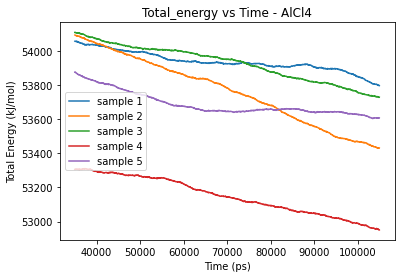

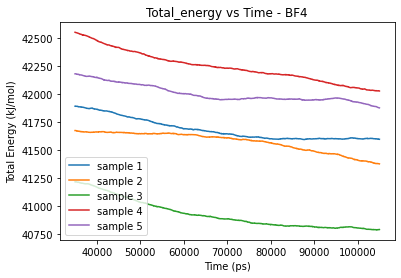

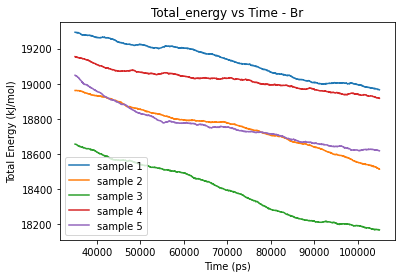

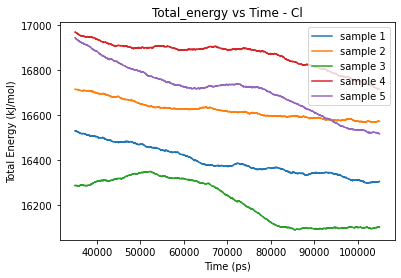

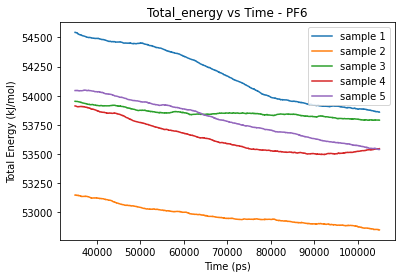

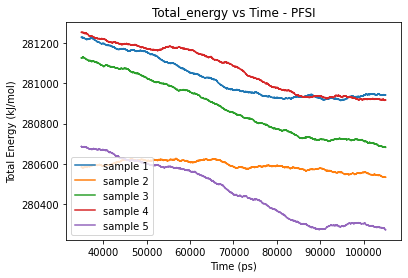

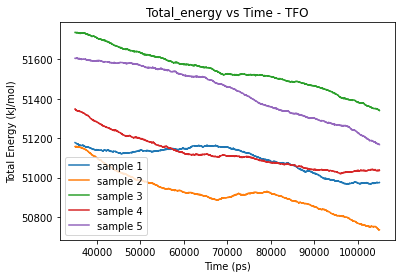

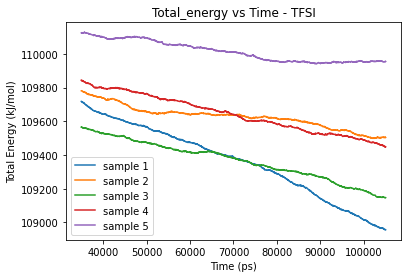

In [15]:
os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
anion = ["AlCl4", "BF4", "Br", "Cl", "PF6", "PFSI", "TFO", "TFSI"]
os.chdir(str(anion[0]))
energies = ["density", "total_energy", "LJ14", "Coulomb-14", "Potential"]
energies = ["total_energy"]
labels = ["Density (kg/m^3)", "Total Energy (kJ/mol)", "LJ-14 (kJ/mol)", "Coulomb-14 (kJ/mol)", "Potential Energy (kJ/mol)"]
labels = ["Total Energy (kJ/mol)"]
window = 30000 # 30ns window for rolling average
for k in anion:
    os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
    os.chdir(str(k))
    for i in energies:
        file = "{}_1.xvg".format(i)
        mdat = np.loadtxt(file)
        ydat = mdat[1:, 1].tolist()
        xdat = mdat[1:, 0].tolist()
        
        yarr = np.array(ydat)
        xarr = np.array(xdat)
        
        yplot = rolling_mean(yarr, window)
        xplot = rolling_mean(xarr, window)
        plt.figure()
        plt.plot(xplot, yplot, label = "sample 1")
        plt.xlabel("Time (ps)")
        
        plt.ylabel(str(labels[energies.index(i)]))
        plt.title(str(i).capitalize() + " vs Time - " + str(k))
        print("Window Size: " + str(window/1000) + " ns")
        #plt.xlim(10000)
        #plt.ylim(0, 1e-5)
        plt.legend()
        for j in range(2, 6):
            file = "{}_{}.xvg".format(i, j)
            mdat = np.loadtxt(file)
            ydat = mdat[1:, 1].tolist()
            xdat = mdat[1:, 0].tolist()
            yarr = np.array(ydat)
            xarr = np.array(xdat)
        
            yplot = rolling_mean(yarr, window)
            xplot = rolling_mean(xarr, window)
            #plt.figure()
            #plt.xlabel("Time (ps)")
            #plt.ylabel("Density (kg/m^3)")
            #plt.title("Density vs Time - AlCl4")
            plt.plot(xplot, yplot, label = "sample " + str(j))
            
            #plt.xlim(10000)
            #plt.ylim(0, 1e-5)
            plt.legend()

Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns
Window Size: 30.0 ns


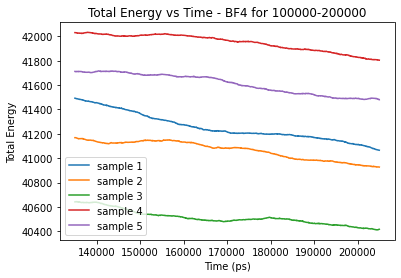

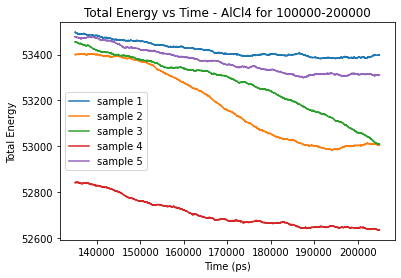

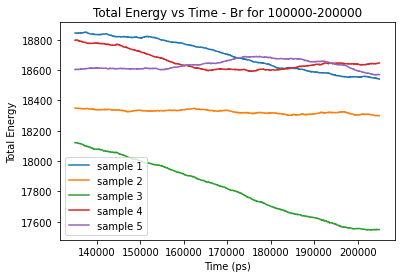

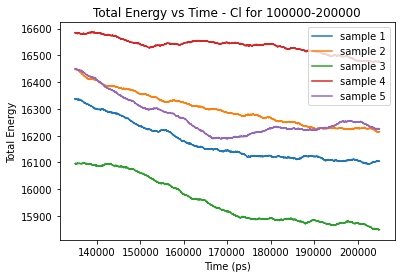

In [27]:
os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
anion = ["BF4", "AlCl4", "Br", "Cl"]
window = 30000
ranges = [200000]
low = 0
for k in anion:
    os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
    os.chdir(str(k))
    for i in ranges:
        low = i - 100000
        file = "total_energy_1_{}_{}.xvg".format(low, i)
        mdat = np.loadtxt(file)
        ydat = mdat[1:, 1].tolist()
        xdat = mdat[1:, 0].tolist()
        yarr = np.array(ydat)
        xarr = np.array(xdat)
        
        yplot = rolling_mean(yarr, window)
        xplot = rolling_mean(xarr, window)
        plt.figure()
        plt.plot(xplot, yplot, label = "sample 1")
        plt.xlabel("Time (ps)")
        
        plt.ylabel("Total Energy")
        plt.title("Total Energy vs Time - " + str(k) + " for " + str(low) + "-" + str(i))
        print("Window Size: " + str(window/1000) + " ns")
        #plt.xlim(10000)
        #plt.ylim(0, 1e-5)
        plt.legend()
        for j in range(2, 6):
            file = "total_energy_{}_{}_{}.xvg".format(j, low, i)
            mdat = np.loadtxt(file)
            ydat = mdat[1:, 1].tolist()
            xdat = mdat[1:, 0].tolist()
            yarr = np.array(ydat)
            xarr = np.array(xdat)
    
            yplot = rolling_mean(yarr, window)
            xplot = rolling_mean(xarr, window)
            #plt.figure()
            #plt.xlabel("Time (ps)")
            #plt.ylabel("Density (kg/m^3)")
            #plt.title("Density vs Time - AlCl4")
            plt.plot(xplot, yplot, label = "sample " + str(j))

            #plt.xlim(10000)
            #plt.ylim(0, 1e-5)
            plt.legend()

In [ ]:
list(cat_diff_dict.items())

### Diffusivity

In [36]:
# Adds dictionaries of anions, diffusivities, and beta values to new DataFrame
cat_diff_df = pd.DataFrame(list(cat_diff_dict.items()), columns = ["Anion", "Cation Diffusivity (nm^2/ps)"])
# Comment Betas when Short Time MSD Used
cat_diff_df["Beta"] = cat_diff_df["Anion"].map(beta_dict) 

cat_diff_df["Cation Diffusivity (cm^2/s)"] = cat_diff_df["Cation Diffusivity (nm^2/ps)"] * 0.01
cat_diff_df = cat_diff_df.drop(columns = ["Cation Diffusivity (nm^2/ps)"])

# Formats Diffusivities to scientific notation and Betas to Standard
cat_diff_df.style.format({
    "Cation Diffusivity (cm^2/s)":"{:,.6E}".format,
    "Beta":"{:,.5f}".format})

,Anion,Beta,Cation Diffusivity (cm^2/s)
0,AlCl4,0.76837,7.697323E-09
1,BF4,0.63297,3.773538E-09
2,Cl,0.35991,1.886795E-09
3,Br,0.56010,1.992487E-09
4,TFSI,0.53246,7.552169E-09
5,PF6,0.67006,3.913462E-09
6,PFSI,0.64386,2.106720E-08
7,TFO,0.56794,4.471942E-09


[Text(0, 0, '7.69732e-09'),
 Text(0, 0, '3.77354e-09'),
 Text(0, 0, '1.8868e-09'),
 Text(0, 0, '1.99249e-09'),
 Text(0, 0, '7.55217e-09'),
 Text(0, 0, '3.91346e-09'),
 Text(0, 0, '2.10672e-08'),
 Text(0, 0, '4.47194e-09')]

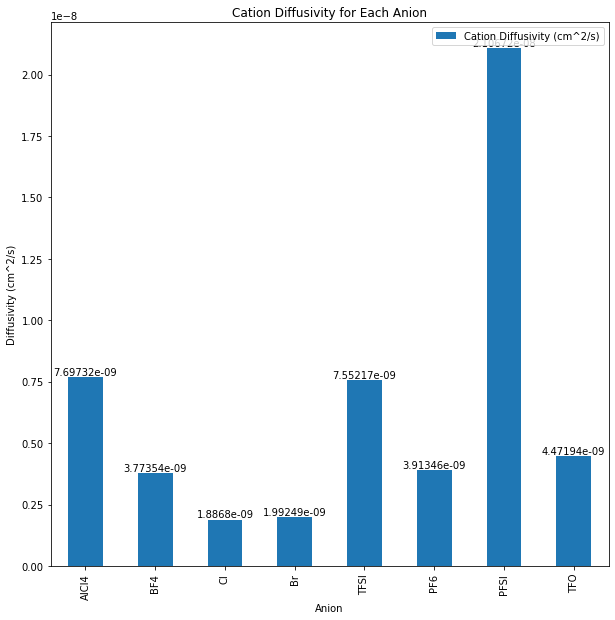

In [24]:
# Bar Graph of Cation Diffusivities
ax = cat_diff_df.plot(x = "Anion", y = "Cation Diffusivity (cm^2/s)", kind = "bar", 
              title = "Cation Diffusivity for Each Anion", figsize = (10, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Diffusivity (cm^2/s)")
ax.bar_label(ax.containers[0])

In [39]:
# Adds dictionaries of anions, diffusivities, and beta values to new DataFrame
lin_cat_diff_df = pd.DataFrame(list(lin_cat_diff_dict.items()), columns = ["Anion", "Linear Fit Cation Diffusivity (nm^2/ps)"])

lin_cat_diff_df["Linear Fit Cation Diffusivity (cm^2/s)"] = lin_cat_diff_df["Linear Fit Cation Diffusivity (nm^2/ps)"] * 0.01
lin_cat_diff_df = lin_cat_diff_df.drop(columns = ["Linear Fit Cation Diffusivity (nm^2/ps)"])

# Formats Diffusivities to scientific notation and Betas to Standard
lin_cat_diff_df.style.format({
    "Linear Fit Cation Diffusivity (cm^2/s)":"{:,.6E}".format})

,Anion,Linear Fit Cation Diffusivity (cm^2/s)
0,AlCl4,8.196521E-09
1,BF4,2.696914E-09
2,Cl,5.539692E-10
3,Br,1.468533E-09
4,TFSI,4.364754E-09
5,PF6,2.354022E-09
6,PFSI,1.254814E-08
7,TFO,2.208433E-09


In [25]:
comb_cat_diff_df = cat_diff_df.set_index("Anion").join(lin_cat_diff_df.set_index("Anion"), rsuffix = " (Cation)")
comb_cat_diff_df.drop(columns = ["Beta"], inplace = True)
comb_cat_diff_df.reset_index(inplace = True)
comb_cat_diff_df

,Anion,Cation Diffusivity (cm^2/s),Linear Fit Cation Diffusivity (cm^2/s)
0,AlCl4,7.697323e-09,8.196521e-09
1,BF4,3.773538e-09,2.696914e-09
2,Cl,1.886795e-09,5.539692e-10
3,Br,1.992487e-09,1.468533e-09
4,TFSI,7.552169e-09,4.364754e-09
5,PF6,3.913462e-09,2.354022e-09
6,PFSI,2.106720e-08,1.254814e-08
7,TFO,4.471942e-09,2.208433e-09


Text(0.5, 1.0, 'Comparison of Short-Time MSD and Linear Fit Diffusivity for Each Cation')

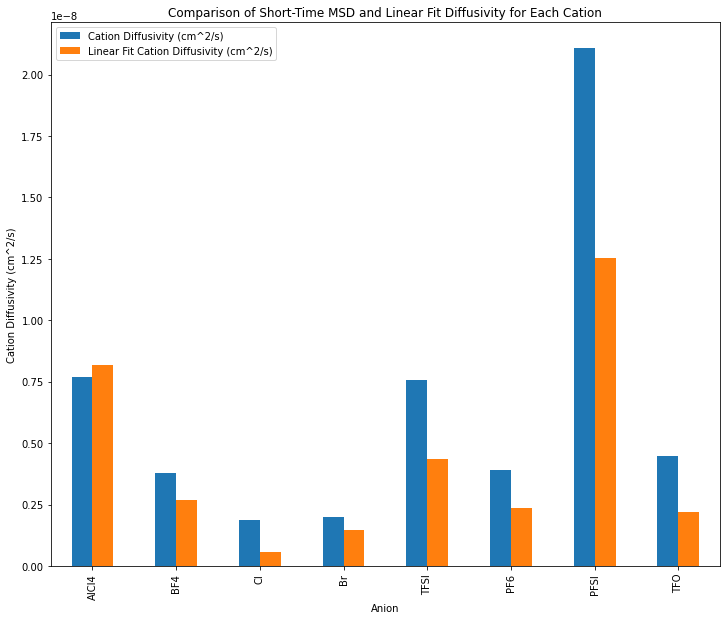

In [26]:
ax = comb_cat_diff_df.plot.bar(x = "Anion", figsize=(12, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Cation Diffusivity (cm^2/s)")
ax.set_title("Comparison of Short-Time MSD and Linear Fit Diffusivity for Each Cation")

## NE Conductivity

In [40]:
cat_diff_list = list(cat_diff_df["Cation Diffusivity (cm^2/s)"])

s_ne = 0.0
cat_diff = 0.0
cat_NE_list = []

for i in range(len(cat_diff_list)):
    cat_diff = cat_diff_list[i]/10000 # Diffusivity in m^2/s
    s_ne = ((q**2*d)/(k_b*T))*((N_cat**2/(N_cat + 1))*cat_diff) # S/m
    s_ne *= 10
    cat_NE_list.append(s_ne)
    
print(cat_NE_list)

NameError: name 'cat_diff_df' is not defined

In [41]:
# Bar Graph of Cation Diffusivities
ax = cat_diff_df.plot(x = "Anion", y = "Cation Diffusivity (cm^2/s)", kind = "bar", 
              title = "Cation Diffusivity for Each Anion", figsize = (10, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Cation Diffusivity (cm^2/s)")
ax.bar_label(ax.containers[0])

NameError: name 'cat_diff_df' is not defined

In [ ]:
cat_diff_df["Cation Nernst-Einstein Conductivity (mS/cm)"] = cat_NE_list
cat_diff_df

In [ ]:
# Bar Graph of NE Conductivity for Each Cation
ax = cat_diff_df.plot(x = "Anion", y = "Cation Nernst-Einstein Conductivity (mS/cm)", kind = "barh", 
              title = "Cation Nernst-Einstein Conductivity for Each Anion", figsize = (12, 10))
ax.set_ylabel("Anion")
ax.set_xlabel("Cation Nernst-Einstein Conductivity (mS/cm)")
ax.bar_label(ax.containers[0])

# Summary

In [19]:
#comb_df = diffs_df.set_index("Anion").join(cat_diff_df.set_index("Anion"), rsuffix = " (Cation)")
comb_df = diffs_df
comb_df = comb_df[["Anion", "Beta", "Diffusivity (cm^2/s)", "Nernst-Einstein Conductivity (mS/cm)"]]
comb_df

,Anion,Beta,Diffusivity (cm^2/s),Nernst-Einstein Conductivity (mS/cm)
0,BF4,0.957834,3.430480e-07,0.246174
1,Cl,0.940908,1.171041e-07,0.084035
2,PF6,0.942844,2.130360e-07,0.152876
3,PFSI,0.962775,3.946085e-07,0.283174
4,TFO,0.953531,1.462493e-07,0.104950
5,AlCl4,0.990084,1.081517e-06,0.776105
6,TFSI,0.984043,6.022451e-07,0.432176
7,Br,0.955787,1.341126e-07,0.096240


## Total Nernst-Einstein Conductivity (DO NOT USE)

In [40]:
# Nernst-Einstein Conductivity Calculation
# s_NE = (N_pair/(V*k_b*T))*(q+^2*D)

# Volume Calculation
x = 5.24074*10**-9 # From prod.gro, in m
V = x**3

# N_pair Calculation; From topol.top
N_an = 300 
N_cat = 20
N_pair = N_an + N_cat

k_b = 1.380649*10**-23 # Boltzmann Constant in m^2 kg s^-2 K^-1

T = 600 # From grompp.mdp, in K
q = 1.602176634*10**-19 # +1 e in Coulombs

m_c = 15
d = (m_c + N_an)/V

tot_NE_list = []
anion_list = list(diffs_df["Anion"])
diff_list = list(diffs_df["Diffusivity (cm^2/s)"])
cat_diff_list = list(cat_diff_df["Cation Diffusivity (cm^2/s)"])

s_ne = 0.0
diff = 0.0

for i in range(len(anion_list)):
    diff = diff_list[i]/10000 # Diffusivity in m^2/s
    cat_diff = cat_diff_list[i]/10000 # Diffusivity in m^2/s
    s_ne = ((q**2*d)/(k_b*T))*(((N_cat**2/(N_cat + 1))*cat_diff) + ((N_cat/(N_cat + 1))*diff)) # S/m
    tot_NE_list.append(s_ne)
    
print(tot_NE_list)

[0.3209823880764683, 0.12437393433469693, 0.16196025999920727, 0.28059356599134067, 0.19200558485605987, 0.7490445535432422, 0.6610819208344311, 0.1443800374859881]


In [41]:
# Volume Calculation
x = 5.24074*10**-9 # From prod.gro, in m
V = x**3

# N_pair Calculation; From topol.top
N_an = 300 
N_cat = 20
N_pair = N_an + N_cat

k_b = 1.380649*10**-23 # Boltzmann Constant in m^2 kg s^-2 K^-1

T = 600 # From grompp.mdp, in K
q = 1.602176634*10**-19 # +1 e in Coulombs

m_c = 15
check_NE_list = []
number_density = ((N_an + N_cat) / (V * k_b * T)) * 10**-4
for i in range(len(anion_list)):
    diff = diff_list[i]
    cat_diff = cat_diff_list[i]
    s_ne = (((1 * m_c ** 2 / (m_c + 1)) * q**2 * cat_diff + (1 * m_c / (m_c + 1)) * q**2 * diff)) * number_density
    check_NE_list.append(s_ne)

check_cond_df = diffs_df.drop(columns = ["Beta", "Diffusivity (cm^2/s)"])
check_cond_df["Ideal Conductivity (S/m)"] = check_NE_list
check_cond_df

,Anion,Ideal Conductivity (S/m)
0,BF4,0.296126
1,Cl,0.112188
2,PF6,0.155867
3,PFSI,0.274159
4,TFO,0.167618
5,AlCl4,0.736407
6,TFSI,0.593051
7,Br,0.129939


In [30]:
ne_cond_diff = diffs_df.drop(columns = ["Beta", "Diffusivity (cm^2/s)"])
ne_cond_diff["Ideal Conductivity (mS/cm)"] = tot_NE_list
ne_cond_diff

,Anion,Ideal Conductivity (mS/cm)
0,BF4,0.250083
1,Cl,0.237715
2,PF6,0.237015
3,PFSI,0.303599
4,TFO,0.118826
5,AlCl4,0.724231
6,TFSI,0.486509
7,Br,0.137166


[Text(0, 0, '0.296126'),
 Text(0, 0, '0.112188'),
 Text(0, 0, '0.155867'),
 Text(0, 0, '0.274159'),
 Text(0, 0, '0.167618'),
 Text(0, 0, '0.736407'),
 Text(0, 0, '0.593051'),
 Text(0, 0, '0.129939')]

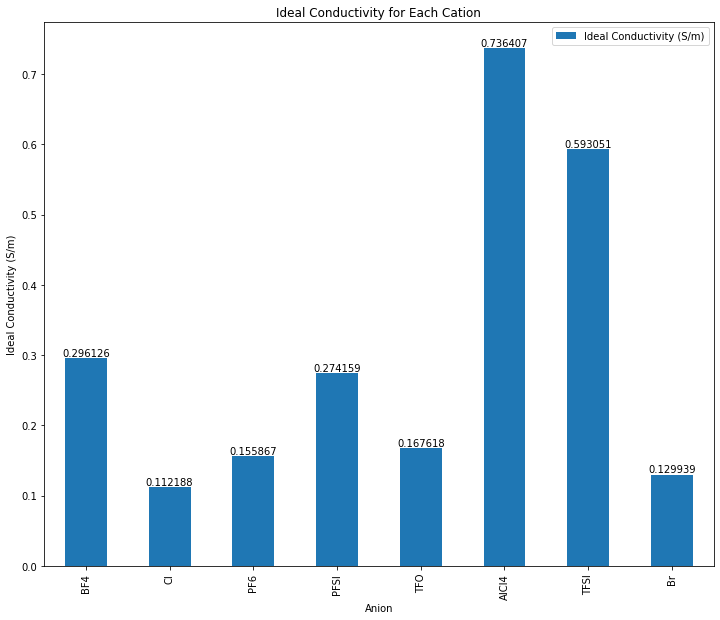

In [33]:
ax = check_cond_df.plot.bar(x = "Anion", figsize=(12, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Ideal Conductivity (S/m)")
ax.set_title("Ideal Conductivity for Each Cation")
ax.bar_label(ax.containers[0])

In [32]:
comb_diff_df = diffs_df.set_index("Anion").join(cat_diff_df.set_index("Anion"), rsuffix = " (Cation)")
comb_diff_df.drop(columns = ["Beta", "Beta (Cation)"], inplace = True)
comb_diff_df.reset_index(inplace = True)
comb_diff_df

,Anion,Diffusivity (cm^2/s),Cation Diffusivity (cm^2/s)
0,BF4,3.430480e-07,3.773538e-09
1,Cl,1.171041e-07,1.886795e-09
2,PF6,2.130360e-07,3.913462e-09
3,PFSI,3.946085e-07,1.254814e-08
4,TFO,1.462493e-07,2.208433e-09
5,AlCl4,1.081517e-06,7.697323e-09
6,TFSI,6.022451e-07,7.552169e-09
7,Br,1.341126e-07,1.992487e-09


Text(0.5, 1.0, 'Cation and Anion Diffusivity')

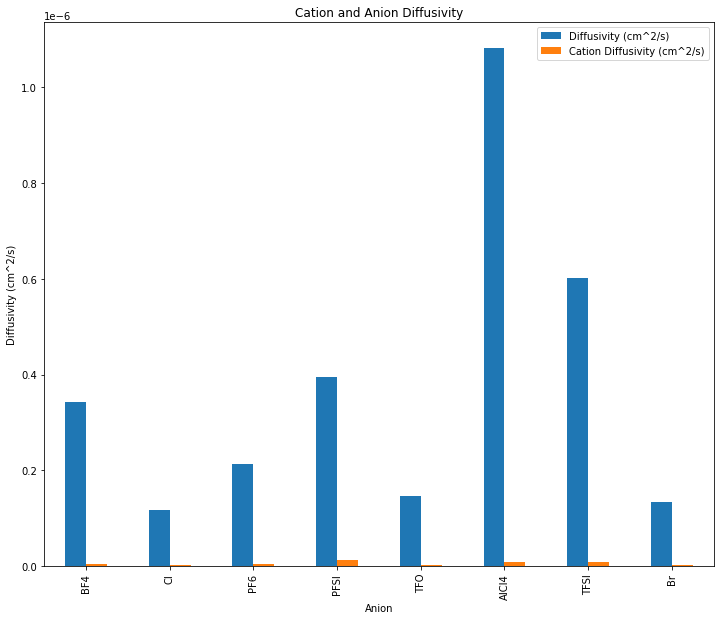

In [34]:
ax = comb_diff_df.plot.bar(x = "Anion", figsize=(12, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Diffusivity (cm^2/s)")
ax.set_title("Cation and Anion Diffusivity")

# External Field

## Anion

<Figure size 960x800 with 0 Axes>

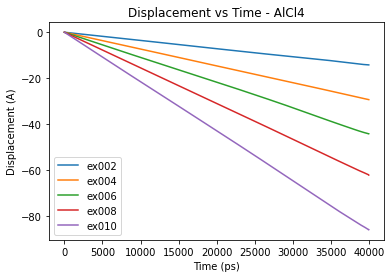

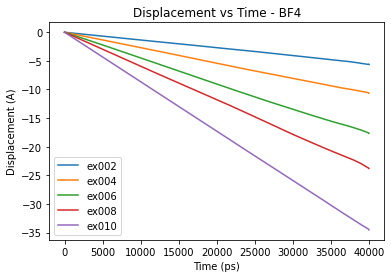

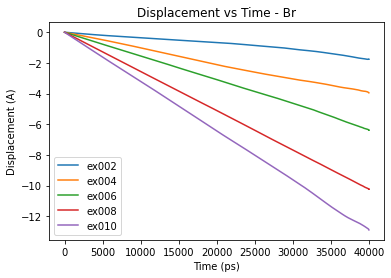

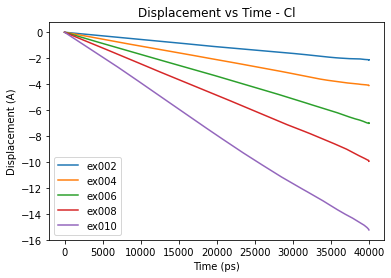

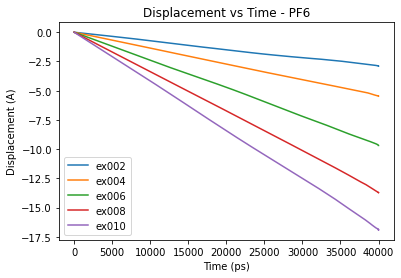

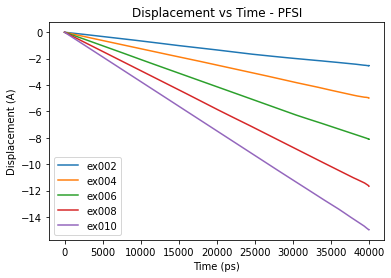

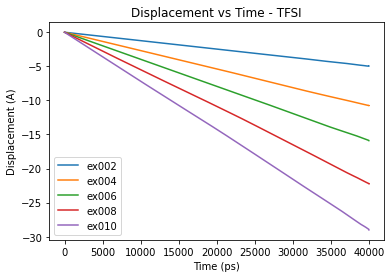

In [15]:
anions = ["AlCl4", "BF4", "Br", "Cl", "PF6", "PFSI", "TFSI"]
external_fields = ["ex002", "ex004", "ex006", "ex008", "ex010"]

#external_fields = ["ex002", "ex004", "ex008", "ex010"] # Comment once all are obtained

cation_dict = {}
cat_diff_dict = {}
cation_diffusivities_dict = {}
slopes_dict = {}
beta_dict = {}
anion_dict = {}
df_dict = {}
diffs_dict = {}


figure(figsize=(12, 10), dpi=80)
os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")

for i in anions:
    os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
    os.chdir(str(i)+"/Drift Velocity/")
    plt.figure()
    for j in external_fields:
        if j == "ex002":
            os.chdir("" + str(j))
        else:
            os.chdir("../" + str(j))
        # Formats file name to include current anion
        f_name = "msd_{}_1.xvg"
    
        # Creates and adds DataFrame of each anion's sample 1 MSD to dictionary of MSDs
        anion_dict["data_{}_{}".format(i, j)] = pd.DataFrame(np.loadtxt(f_name.format(i)), columns = ["Time", "Displacement 1"])
        # Adds MSD of samples 2-5 for each anion to the same dataframe
        for k in range(2, 6):
            file = "msd_{}_{}.xvg".format(i, k)
            m_dat = np.loadtxt(file.format(k))
            col_name = "Displacement {}"
            anion_dict["data_{}_{}".format(i, j)][col_name.format(k)] = m_dat[:, 1].tolist()
    
        # Averages all sample MSDs for each anion to create Mean MSD
        anion_dict["data_{}_{}".format(i, j)]["Mean Displacement"] = anion_dict["data_{}_{}".format(i, j)].iloc[:, 1:5].mean(axis = 1)
        #print("MSD vs Time for Cation in " + i + " with External Field " + j)
        #display(anion_dict["data_{}_{}".format(i, j)].tail())
    
        # Log-Log Plot of Time vs Mean MSD for each anion
        plt.plot("Time", "Mean Displacement", data = anion_dict["data_{}_{}".format(i, j)], label = j)
        #plt.xlabel("Log Time (ps)")
        #plt.ylabel("Log MSD (nm/S^2)")
        plt.title("Displacement vs Time - " + str(i))
        plt.xlabel("Time (ps)")
        plt.ylabel("Displacement (A)")
        #plt.xscale("log")
        #plt.yscale("log")
        plt.legend()
        
        # Gets times and Mean MSDs for each anion within diffusive region
        time = anion_dict["data_{}_{}".format(i, j)]["Time"].drop(0)
        msd = anion_dict["data_{}_{}".format(i, j)]["Mean Displacement"].drop(0)
    
        # Computes slope of line of best fit from times and Mean MSDs
        slopes_dict[str(i)+str(j)] = np.polyfit(time.values, msd.values, 1)[0]
    
        # Get Beta Value as Slope of Log-Log Plot of MSD vs Time over Diffusive Region
        log_time = np.log(time)
        log_msd = np.log(time)
    
        beta_dict[str(i)+str(j)] = np.polyfit(log_time.values, log_msd.values, 1)[0]

## Partial Conductivity

In [19]:
# Dictionaries of Drift Velocities, Anions, and Beta Values
vel_df = pd.DataFrame(list(slopes_dict.items()), columns = ["Anion", "Drift Velocity (A/ps)"])
vel_df["Beta"] = vel_df["Anion"].map(beta_dict)
vel_df["Drift Velocity (m/s)"] = vel_df["Drift Velocity (A/ps)"] * 100
vel_df = vel_df.drop(columns = ["Drift Velocity (A/ps)"])

# Formats Diffusivities to scientific notation and Betas to Standard
vel_df.style.format({
    "Drift Velocity (m/s)":"{:,.6f}".format,
    "Beta":"{:,.5f}".format})

,Anion,Beta,Drift Velocity (m/s)
0,AlCl4ex002,1.00000,-0.035579
1,AlCl4ex004,1.00000,-0.073325
2,AlCl4ex006,1.00000,-0.110566
3,AlCl4ex008,1.00000,-0.155571
4,AlCl4ex010,1.00000,-0.215789
5,BF4ex002,1.00000,-0.013720
6,BF4ex004,1.00000,-0.026656
7,BF4ex006,1.00000,-0.044302
8,BF4ex008,1.00000,-0.059106
9,BF4ex010,1.00000,-0.086284


## Cation

<Figure size 960x800 with 0 Axes>

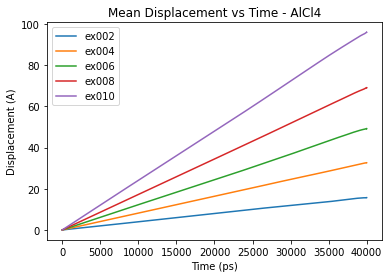

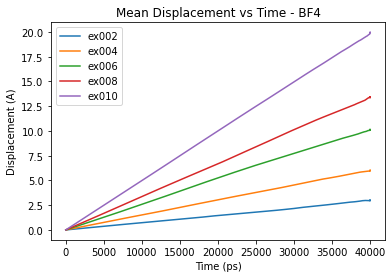

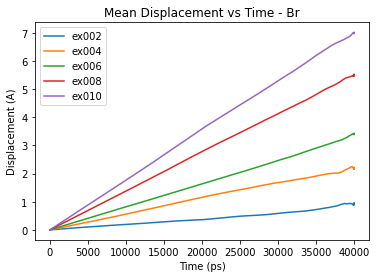

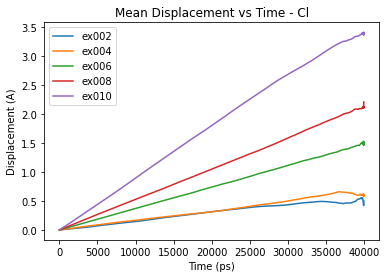

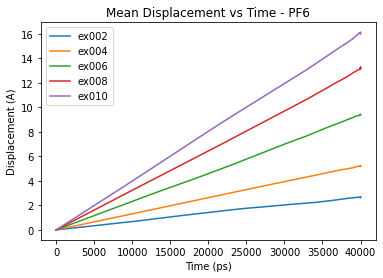

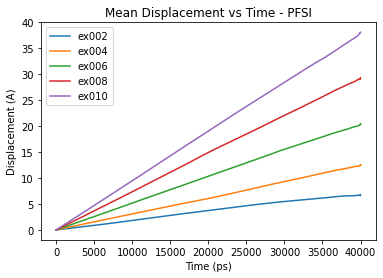

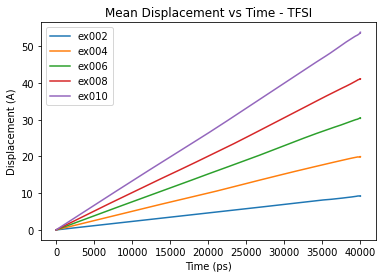

In [20]:
cation_dict = {}
cat_diff_dict = {}
cation_diffusivities_dict = {}
slopes_dict = {}
beta_dict = {}



#anions = ["Br", "AlCl4"] #Comment this once all cation msds are obtained
anions = ["AlCl4", "BF4", "Br", "Cl", "PF6", "PFSI", "TFSI"]

os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")

figure(figsize=(12, 10), dpi=80)

for i in anions:
    os.chdir("C:/Users/User/OneDrive - The University of Texas at Austin/Ram/Documents/UT/Research/Dr. Ganesan Research/MSD Files")
    os.chdir(str(i)+"/Drift Velocity/")
    plt.figure()
    for j in external_fields:
        if j == "ex002":
            os.chdir("" + str(j))
        else:
            os.chdir("../" + str(j))
        f_name = "msd_cat_{}_1.xvg"
        cation_dict["data_{}_{}".format(i, j)] = pd.DataFrame(np.loadtxt(f_name.format(i)), columns = ["Time", "Displacement 1"])
        # Adds MSD of samples 2-5 for each anion to the same dataframe
        for k in range(2, 6):
            file = "msd_cat_{}_{}.xvg".format(i, k)
            m_dat = np.loadtxt(file.format(k))
            col_name = "Displacement {}"
            cation_dict["data_{}_{}".format(i, j)][col_name.format(k)] = m_dat[:, 1].tolist()
    
        # Averages all sample MSDs for each anion to create Mean MSD
        cation_dict["data_{}_{}".format(i, j)]["Mean Displacement"] = cation_dict["data_{}_{}".format(i, j)].iloc[:, 1:5].mean(axis = 1)
        #print("MSD vs Time for Cation in " + i + " with External Field " + j)
        #display(cation_dict["data_{}_{}".format(i, j)].tail())
    
        # Log-Log Plot of Time vs Mean MSD for each anion
        plt.plot("Time", "Mean Displacement", data = cation_dict["data_{}_{}".format(i, j)], label = j)
        #plt.xlabel("Log Time (ps)")
        #plt.ylabel("Log MSD (nm/S^2)")
        plt.title("Mean Displacement vs Time - " + str(i))
        plt.xlabel("Time (ps)")
        plt.ylabel("Displacement (A)")
        #plt.xscale("log")
        #plt.yscale("log")
        plt.legend()
    
   
        # Gets times and Mean MSDs for each anion within diffusive region
        time = cation_dict["data_{}_{}".format(i, j)]["Time"].drop(0)
        msd = cation_dict["data_{}_{}".format(i, j)]["Mean Displacement"].drop(0)
    
        # Computes slope of line of best fit from times and Mean MSDs
        slopes_dict[str(i) + str(j)] = np.polyfit(time.values, msd.values, 1)[0]
    
        # Get Beta Value as Slope of Log-Log Plot of MSD vs Time over Diffusive Region
        log_time = np.log(time)
        log_msd = np.log(msd)
    
        beta_dict[str (i) + str (j)] = np.polyfit(log_time.values, log_msd.values, 1)[0]

In [29]:
cation_dict["data_AlCl4_ex010"]["Displacement 4"]

0          0.00000
1          0.00251
2          0.00502
3          0.00753
4          0.01004
           ...    
39996    100.27348
39997    100.36061
39998    100.43098
39999    100.39968
40000    100.36498
Name: Displacement 4, Length: 40001, dtype: float64

## Drift Velocity

In [21]:
# Dictionaries of Drift Velocities, Anions, and Beta Values
cat_vel_df = pd.DataFrame(list(slopes_dict.items()), columns = ["Anion", "Drift Velocity (A/ps)"])
cat_vel_df["Beta"] = cat_vel_df["Anion"].map(beta_dict)
cat_vel_df["Drift Velocity (m/s)"] = cat_vel_df["Drift Velocity (A/ps)"] * 100
cat_vel_df = cat_vel_df.drop(columns = ["Drift Velocity (A/ps)"])

# Formats Diffusivities to scientific notation and Betas to Standard
cat_vel_df.style.format({
    "Drift Velocity (m/s)":"{:,.6f}".format,
    "Beta":"{:,.5f}".format})

,Anion,Beta,Drift Velocity (m/s)
0,AlCl4ex002,1.00162,0.039436
1,AlCl4ex004,0.99994,0.081685
2,AlCl4ex006,0.99808,0.123327
3,AlCl4ex008,0.99956,0.172854
4,AlCl4ex010,0.99965,0.241009
5,BF4ex002,0.99405,0.007410
6,BF4ex004,1.00100,0.015109
7,BF4ex006,1.00447,0.025507
8,BF4ex008,1.00080,0.033532
9,BF4ex010,1.00108,0.049705


In [22]:
tot_vel_df = vel_df.set_index("Anion").join(cat_vel_df.set_index("Anion"), rsuffix = " (Cation)")
tot_vel_df.drop(columns = ["Beta", "Beta (Cation)"], inplace = True)
tot_vel_df.rename(columns = {"Drift Velocity (m/s) (Cation)": "Cation Drift Velocity (m/s)"}, inplace = True)
tot_vel_df.reset_index(inplace = True)

anion = tot_vel_df["Anion"].tolist()
anion_name = [i[:-5] for i in anion]
field_strength = [i[-3:] for i in anion]
field_strength = list(map(float, field_strength))
field_strength  = [i / 100 for i in field_strength]
tot_vel_df.drop(columns = ["Anion"], inplace = True)

ind = list(zip(anion_name, field_strength))
index = pd.MultiIndex.from_tuples(ind, names=["Anion", "Field Strength"])
tot_vel_df.set_index(index, inplace = True)

tot_vel_df

Drift Velocity (m/s)  Cation Drift Velocity (m/s)
Anion Field Strength                                                   
AlCl4 0.02                       -0.035579                     0.039436
      0.04                       -0.073325                     0.081685
      0.06                       -0.110566                     0.123327
      0.08                       -0.155571                     0.172854
      0.10                       -0.215789                     0.241009
BF4   0.02                       -0.013720                     0.007410
      0.04                       -0.026656                     0.015109
      0.06                       -0.044302                     0.025507
      0.08                       -0.059106                     0.033532
      0.10                       -0.086284                     0.049705
Br    0.02                       -0.004019                     0.002145
      0.04                       -0.009917                     0.005502
      0.06                       -0.015680                     0.008318
      0.08                       -0.025594                     0.013778
      0.10                       -0.032271                     0.017630
Cl    0.02                       -0.005439                     0.001361
      0.04                       -0.010554                     0.001679
      0.06                       -0.017330                     0.003713
      0.08                       -0.024392                     0.005325
      0.10                       -0.038267                     0.008768
PF6   0.02                       -0.007144                     0.006705
      0.04                       -0.013505                     0.013094
      0.06                       -0.024018                     0.023424
      0.08                       -0.033898                     0.032585
      0.10                       -0.041818                     0.039936
PFSI  0.02                       -0.006424                     0.017544
      0.04                       -0.012532                     0.031120
      0.06                       -0.020392                     0.051181
      0.08                       -0.029052                     0.073323
      0.10                       -0.037288                     0.094477
TFSI  0.02                       -0.012383                     0.023145
      0.04                       -0.027010                     0.050457
      0.06                       -0.039738                     0.076394
      0.08                       -0.055325                     0.102392
      0.10                       -0.072069                     0.133650

In [23]:
for i in anions:
    print(i)
    plot_df = tot_vel_df.loc[i]
    plot_df.reset_index(inplace = True)
    display(plot_df)

AlCl4


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.035579,0.039436
1,0.04,-0.073325,0.081685
2,0.06,-0.110566,0.123327
3,0.08,-0.155571,0.172854
4,0.10,-0.215789,0.241009


BF4


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.013720,0.007410
1,0.04,-0.026656,0.015109
2,0.06,-0.044302,0.025507
3,0.08,-0.059106,0.033532
4,0.10,-0.086284,0.049705


Br


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.004019,0.002145
1,0.04,-0.009917,0.005502
2,0.06,-0.015680,0.008318
3,0.08,-0.025594,0.013778
4,0.10,-0.032271,0.017630


Cl


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.005439,0.001361
1,0.04,-0.010554,0.001679
2,0.06,-0.017330,0.003713
3,0.08,-0.024392,0.005325
4,0.10,-0.038267,0.008768


PF6


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.007144,0.006705
1,0.04,-0.013505,0.013094
2,0.06,-0.024018,0.023424
3,0.08,-0.033898,0.032585
4,0.10,-0.041818,0.039936


PFSI


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.006424,0.017544
1,0.04,-0.012532,0.031120
2,0.06,-0.020392,0.051181
3,0.08,-0.029052,0.073323
4,0.10,-0.037288,0.094477


TFSI


,Field Strength,Drift Velocity (m/s),Cation Drift Velocity (m/s)
0,0.02,-0.012383,0.023145
1,0.04,-0.027010,0.050457
2,0.06,-0.039738,0.076394
3,0.08,-0.055325,0.102392
4,0.10,-0.072069,0.133650


In [24]:
def cond_fit(x, k):
    return k*x

Anion: -0.18936810742926236
Cation: 0.21070048118253654
Anion: -0.07272744797065882
Cation: 0.04137919641919425
Anion: -0.028878333691333295
Cation: 0.015536063915351624
Anion: -0.02935067357177897
Cation: 0.006193584596372684
Anion: -0.04029998640283041
Cation: 0.03891781996819508
Anion: -0.03481191675954035
Cation: 0.08776931646325771
Anion: -0.06781917109315172
Cation: 0.1271343626273933


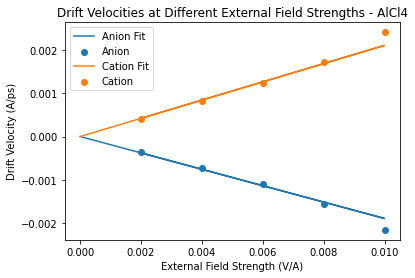

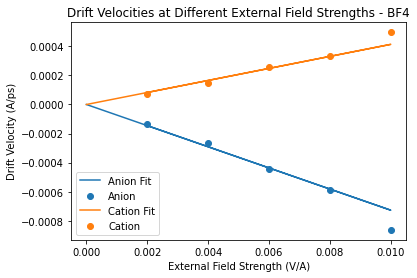

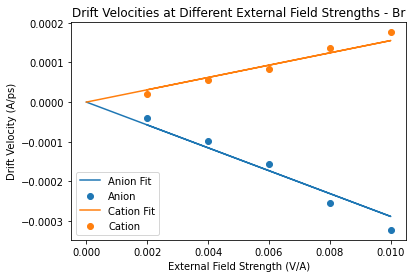

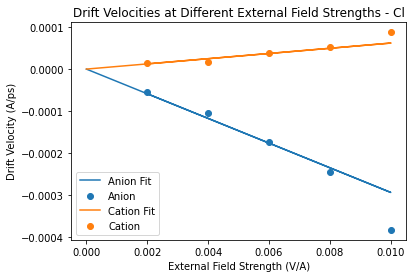

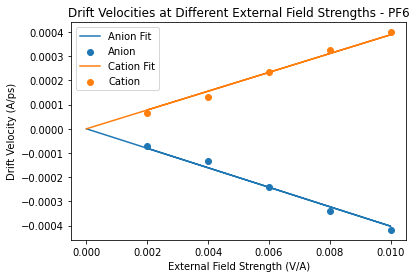

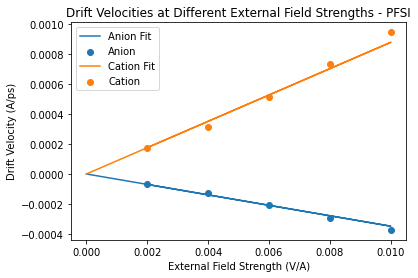

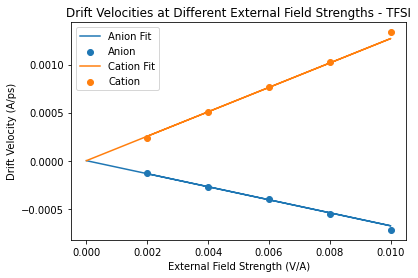

In [25]:
an_slopes_dict = {}
cat_slopes_dict = {}

for i in anions:
    plot_df = tot_vel_df.loc[i]
    plot_df.reset_index(inplace = True)
    
    # Convert Field Strength to V/m from V/nm
    plot_df["Field Strength (V/A)"] = plot_df["Field Strength"] / 10
    plot_df["Drift Velocity (A/ps)"] = plot_df["Drift Velocity (m/s)"] * 0.01
    plot_df["Cation Drift Velocity (A/ps)"] = plot_df["Cation Drift Velocity (m/s)"] * 0.01
    
    plt.figure()
    
    # Anion Line of Best Fit
    fit_df = plot_df.iloc[:-1, :]
    xdat = fit_df["Field Strength (V/A)"].tolist()
    ydat = fit_df["Drift Velocity (A/ps)"].tolist()
    popt, pcov = curve_fit(cond_fit, xdat, ydat)
    print("Anion: " + str(popt[0]))
    an_slopes_dict[i] = popt[0]
    xplot = plot_df["Field Strength (V/A)"].tolist()
    xplot.append(0)
    yplot = [an_slopes_dict[i]*k for k in xplot]
    plt.plot(xplot, yplot, label = "Anion Fit")
    
    # Anion Scatter Plot
    plt.scatter("Field Strength (V/A)" , "Drift Velocity (A/ps)", data = plot_df, label = "Anion")
    plt.xlabel("External Field Strength (V/A)")
    plt.ylabel("Drift Velocity (A/ps)")
    plt.title("Drift Velocities at Different External Field Strengths - " + str(i))
    
    # Cation Line of Best Fit
    xdat = fit_df["Field Strength (V/A)"].tolist()
    ydat = fit_df["Cation Drift Velocity (A/ps)"].tolist()
    popt, pcov = curve_fit(cond_fit, xdat, ydat)
    print("Cation: " + str(popt[0]))
    cat_slopes_dict[i] = popt[0]
    yplot = [cat_slopes_dict[i]*k for k in xplot]
    plt.plot(xplot, yplot, label = "Cation Fit")
    
    # Cation Scatter Plot
    plt.scatter("Field Strength (V/A)" , "Cation Drift Velocity (A/ps)", data = plot_df, label = "Cation")
    plt.legend()

## True Conductivity

In [26]:
cat_slopes_dict

{'AlCl4': 0.21070048118253654,
 'BF4': 0.04137919641919425,
 'Br': 0.015536063915351624,
 'Cl': 0.006193584596372684,
 'PF6': 0.03891781996819508,
 'PFSI': 0.08776931646325771,
 'TFSI': 0.1271343626273933}

In [27]:
an_slopes_dict

{'AlCl4': -0.18936810742926236,
 'BF4': -0.07272744797065882,
 'Br': -0.028878333691333295,
 'Cl': -0.02935067357177897,
 'PF6': -0.04029998640283041,
 'PFSI': -0.03481191675954035,
 'TFSI': -0.06781917109315172}

In [36]:
cat_cond_dict = {}
an_cond_dict = {}
cond_dict = {}

# Volume Calculation
anions = ["BF4", "Cl", "PF6", "PFSI", "TFO", "AlCl4", "TFSI", "Br"]
box_x = [4.78088*10**-9, 4.50819*10**-9, 4.93025*10**-9, 5.77273*10**-9, 4.94393*10**-9, 5.24735*10**-9, 5.36238*10**-9, 4.53440*10**-9] # From prod.gro, in m
V_anion = [x**3 for x in box_x]

# Number Density Calculation; From topol.top
N_an = 300 
N_cat = 20

q = 1.602176634*10**-19 # +1 e in Coulombs

number_density = [N_an/V for V in V_anion]

for i in enumerate(anions):
    #cond_dict[i] = ((-q*an_slopes_dict[i]*10**-8) + (q*cat_slopes_dict[i]*10**-8)) * number_density # Conductivity in S/m
    ind = i[1]
    cond_dict[ind] = ((-q*an_slopes_dict[ind]*10**-8)) * number_density[i[0]] * 10 # Convert to mS/cm
    
cond_dict

{'AlCl4': 8.329423773359434,
 'BF4': 3.8152531780604013,
 'Br': 1.1582357176100404,
 'Cl': 0.7333410311658355,
 'PF6': 1.602948645755807,
 'PFSI': 1.1580824670151844,
 'TFSI': 2.1140310708162495}

In [37]:
cond_df = pd.DataFrame(cond_dict.items(), columns = ["Anion", "Conductivity (mS/cm)"])
cond_df

,Anion,Conductivity (mS/cm)
0,AlCl4,8.329424
1,BF4,3.815253
2,Br,1.158236
3,Cl,0.733341
4,PF6,1.602949
5,PFSI,1.158082
6,TFSI,2.114031


[Text(0, 0, '8.32942'),
 Text(0, 0, '3.81525'),
 Text(0, 0, '1.15824'),
 Text(0, 0, '0.733341'),
 Text(0, 0, '1.60295'),
 Text(0, 0, '1.15808'),
 Text(0, 0, '2.11403')]

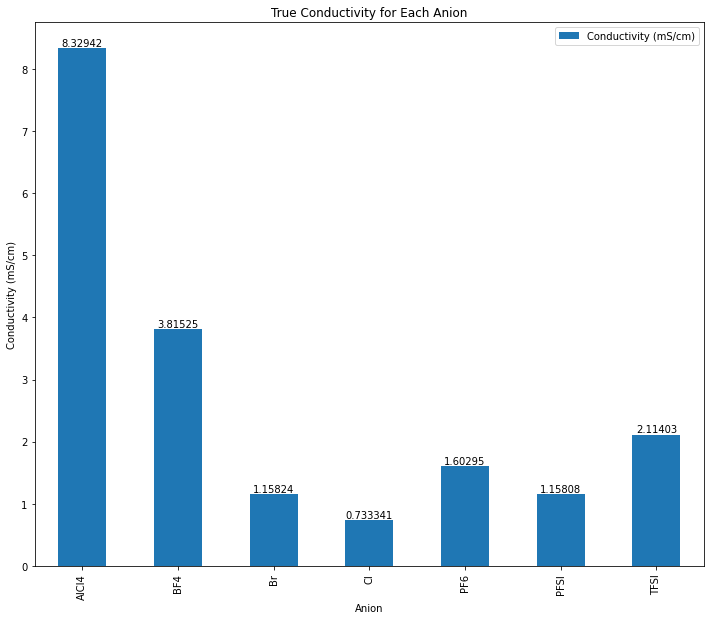

In [38]:
ax = cond_df.plot.bar(x = "Anion", figsize=(12, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Conductivity (mS/cm)")
ax.set_title("True Conductivity for Each Anion")
ax.bar_label(ax.containers[0])

# Inverse Haven Ratio (DO NOT USE)

In [55]:
haven_df = pd.concat([cond_df, check_cond_df], axis = 1)
haven_df

,Anion,Conductivity (S/m),Anion,Ideal Conductivity (S/m)
0,AlCl4,1.335944,BF4,0.296126
1,BF4,0.381035,Cl,0.112188
2,Br,0.148312,PF6,0.155867
3,Cl,0.118692,PFSI,0.274159
4,PF6,0.264531,TFO,0.167618
5,PFSI,0.409334,AlCl4,0.736407
6,TFSI,0.651006,TFSI,0.593051
7,NaN,NaN,Br,0.129939


In [56]:
ideal_df = check_cond_df.drop([4])
ne_df = ideal_df.reindex([5, 0, 7, 1, 2, 3, 6])
ne_df.set_index(["Anion"], inplace = True)
ne_df.reset_index(inplace = True)
ne_df["Temp An"] = ne_df["Anion"]
ne_df.drop(columns = ["Anion"], inplace = True)
ne_df

,Ideal Conductivity (S/m),Temp An
0,0.736407,AlCl4
1,0.296126,BF4
2,0.129939,Br
3,0.112188,Cl
4,0.155867,PF6
5,0.274159,PFSI
6,0.593051,TFSI


In [57]:
haven_df = pd.concat([cond_df, ne_df], axis = 1)
haven_df

,Anion,Conductivity (S/m),Ideal Conductivity (S/m),Temp An
0,AlCl4,1.335944,0.736407,AlCl4
1,BF4,0.381035,0.296126,BF4
2,Br,0.148312,0.129939,Br
3,Cl,0.118692,0.112188,Cl
4,PF6,0.264531,0.155867,PF6
5,PFSI,0.409334,0.274159,PFSI
6,TFSI,0.651006,0.593051,TFSI


In [60]:
haven_df["Inverse Haven Ratio"] = haven_df["Conductivity (S/m)"] / haven_df["Ideal Conductivity (S/m)"]
#haven_df.drop(columns = ["Beta", "Beta (Cation)"], inplace = True)

In [58]:
haven_df.drop(columns = ["Temp An"], inplace = True)
haven_df

,Anion,Conductivity (S/m),Ideal Conductivity (S/m)
0,AlCl4,1.335944,0.736407
1,BF4,0.381035,0.296126
2,Br,0.148312,0.129939
3,Cl,0.118692,0.112188
4,PF6,0.264531,0.155867
5,PFSI,0.409334,0.274159
6,TFSI,0.651006,0.593051


[Text(0, 0, '1.81414'),
 Text(0, 0, '1.28673'),
 Text(0, 0, '1.1414'),
 Text(0, 0, '1.05798'),
 Text(0, 0, '1.69715'),
 Text(0, 0, '1.49305'),
 Text(0, 0, '1.09772')]

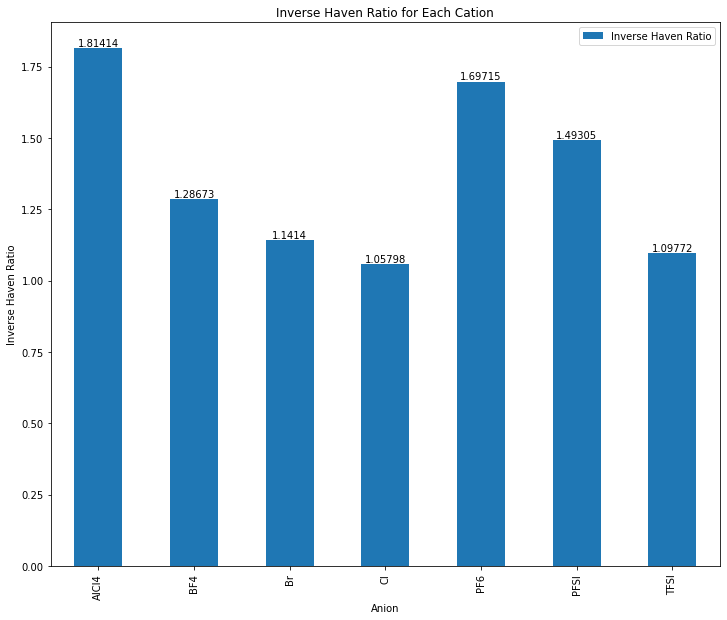

In [61]:
ax = haven_df.plot.bar(x = "Anion", y = "Inverse Haven Ratio", figsize=(12, 10))
ax.set_xlabel("Anion")
ax.set_ylabel("Inverse Haven Ratio")
ax.set_title("Inverse Haven Ratio for Each Cation")
ax.bar_label(ax.containers[0])

# Partial Ionicity

In [39]:
pion_df = cond_df
pion_df["Nernst-Einstein Conductivity (mS/cm)"] = diffs_df["Nernst-Einstein Conductivity (mS/cm)"]
pion_df["Partial Ionicity"] = pion_df["Conductivity (mS/cm)"]/pion_df["Nernst-Einstein Conductivity (mS/cm)"]
pion_df

,Anion,Conductivity (mS/cm),Nernst-Einstein Conductivity (mS/cm),Partial Ionicity
0,AlCl4,8.329424,0.324262,25.687309
1,BF4,3.815253,0.132017,28.899660
2,Br,1.158236,0.183616,6.307916
3,Cl,0.733341,0.211879,3.461133
4,PF6,1.602949,0.125009,12.822651
5,PFSI,1.158082,0.773176,1.497825
6,TFSI,2.114031,0.403428,5.240176
